#Visualização do modelo e Área de Interesse

##Bibliotecas
Instalação e importação das bibliotecas que usaremos para a visualização das fontes de dados

In [ ]:
!pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 4.4 MB/s 
     |████████████████████████████████| 6.3 MB 37.3 MB/s 
     |████████████████████████████████| 16.7 MB 309 kB/s 


In [ ]:
import geopandas as gpd
from geopandas import GeoSeries
from shapely.geometry import Polygon, Point
import pandas as pd
import folium
import branca
import branca.colormap as cm

##Geração do Mapa
Geramos as diferentes zonas pluviométricas para a criação dos modelos e representamos em cores diferentes as diferentes estações.

In [ ]:
m = folium.Map([-22.925778948753702, -43.489029909370046], zoom_start=10, tiles='cartodbpositron')

colormap = ['magenta', 'red', 'orange', 'yellow']
folium.LatLngPopup().add_to(m)
rj = gpd.read_file('Zonas_Pluviometricas.shp')
folium.GeoJson(rj).add_to(m)
folium.LatLngPopup().add_to(m)

m

In [ ]:
df_estacoes = pd.read_csv('estacoes_pluviometricas.csv')

#Estações COR
df_estacoes_pluviometricas = df_estacoes[~df_estacoes['N'].isin([1,11,16,19,20,22,28,32])]
df_estacoes_meteorologicas = df_estacoes[df_estacoes['N'].isin([1,11,16,19,20,22,28,32])]


#Estações INMET
dfnew = pd.read_json('https://apitempo.inmet.gov.br/estacoes/T')
df_estacoes_INMET = dfnew[dfnew['SG_ESTADO'] == 'RJ']

inmet_oeste = ['A636','A621','A602']
inmet_sul = ['A652']

#Desenhar as estações pluviométricas do COR em vermelho
lat = list(df_estacoes_pluviometricas.Latitude)
lon = list(df_estacoes_pluviometricas.Longitude)

for loc in zip(lat, lon):
    folium.Circle(
        location=loc,
        radius=20,
        fill=True,
        color='red',
        fill_opacity=0.7
    ).add_to(m)

#Desenhar as estações meteorológicas do COR em verde
lat = list(df_estacoes_meteorologicas.Latitude)
lon = list(df_estacoes_meteorologicas.Longitude)

for loc in zip(lat, lon):
    folium.Circle(
        location=loc,
        radius=20,
        fill=True,
        color='green',
        fill_opacity=0.7
    ).add_to(m)

#Desenhar as estações meteorológicas do INMET em roxo
lat = list(df_estacoes_INMET.VL_LATITUDE)
lon = list(df_estacoes_INMET.VL_LONGITUDE)

for loc in zip(lat, lon):
    folium.Circle(
        location=loc,
        radius=20,
        fill=True,
        color='purple',
        fill_opacity=0.7
    ).add_to(m)

m

#Primeiro Experimento do Modelo, para Prever Temperatura
Para esse experimento foram utilizados os dados de duas estações, para prever a variável temperatura.

##Bibliotecas
Instalação e importação das bibliotecas que usaremos para o experimento com os modelos

In [ ]:
from numpy import array
import torch
import gc
import torch.nn as nn
from tqdm import tqdm_notebook as tqdm
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import requests, zipfile, io
import matplotlib.pyplot as plt
import os
import seaborn as sns
from torch.utils.data import TensorDataset

##São Cristóvão

###Importação de Dados

In [ ]:
df = pd.read_csv('sao_cristovao.csv')
del df['Unnamed: 0']
df = df.fillna(0)

df = df.reindex(sorted(df.columns), axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731548 entries, 0 to 731547
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Chuva        731548 non-null  float64
 1   Dia          731548 non-null  object 
 2   DirVento     731548 non-null  float64
 3   HBV          731548 non-null  object 
 4   Hora         731548 non-null  object 
 5   Pressao      731548 non-null  float64
 6   Temperatura  731548 non-null  float64
 7   Umidade      731548 non-null  float64
 8   VelVento     731548 non-null  float64
 9   estacao      731548 non-null  object 
dtypes: float64(6), object(4)
memory usage: 55.8+ MB


###Preparação de dados

Variáveis de Vento

Text(0, 0.5, 'Wind Velocity [m/s]')

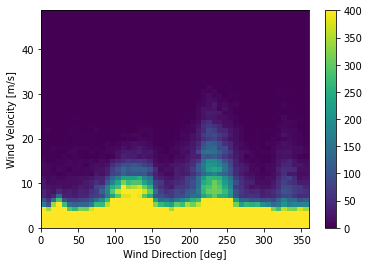

In [ ]:
plt.hist2d(df['DirVento'].fillna(0), df['VelVento'].fillna(0), bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind Direction [deg]')
plt.ylabel('Wind Velocity [m/s]')

(-34.110842134528475, 43.55705582024557, -43.670821831503254, 40.8937707318964)

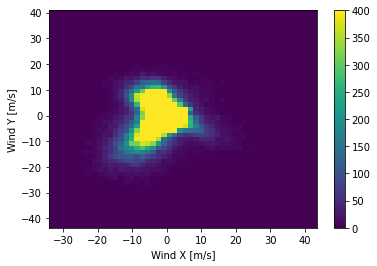

In [ ]:
wv = df['VelVento']
wd_rad = df['DirVento']*np.pi / 180

df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

plt.hist2d(df['Wx'].fillna(0), df['Wy'].fillna(0), bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
ax = plt.gca()
ax.axis('tight')

Variáveis Cíclicas

###Divisão dos Dados

In [ ]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]
print('Conjunto de treinamento')
print(train_df.shape)
print('\n')

print('Conjunto de Validação')
print(val_df.shape)
print('\n')

print('Conjunto de Teste')
print(test_df.shape)

Conjunto de treinamento
(512083, 12)


Conjunto de Validação
(146310, 12)


Conjunto de Teste
(73155, 12)


###Normalização dos Dados

In [ ]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


Removendo os dados descritivos

In [ ]:
train_df = train_df.drop(columns=['Dia','Hora','HBV','estacao'])
val_df = val_df.drop(columns=['Dia','Hora','HBV','estacao'])
test_df = test_df.drop(columns=['Dia','Hora','HBV','estacao'])

###Representação dos Dados

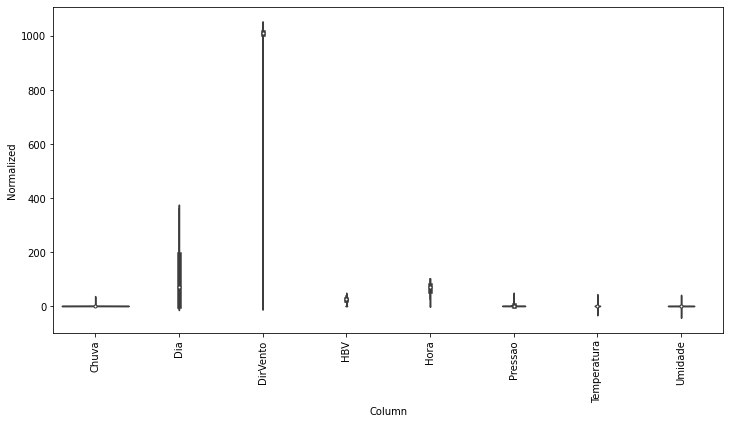

In [ ]:
df_std = (df - train_mean) / train_std
df2 = df.drop(columns=['Dia','Hora','HBV','estacao'])
df_std2 = df2.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x=df_std2['Column'], y=df_std2['Normalized'].astype('float64'))
_ = ax.set_xticklabels(df.keys(), rotation=90)

###Janelamento

In [ ]:
train_arr = np.array(train_df)
val_arr = np.array(val_df)
test_arr = np.array(test_df)


print('Conjunto de Treinamento')
print(train_arr.shape)

print('Conjunto de Validação')
print(val_arr.shape)

print('Conjunto de Teste')
print(test_arr.shape)

Conjunto de Treinamento
(512083, 8)
Conjunto de Validação
(146310, 8)
Conjunto de Teste
(73155, 8)


Criação da função de Janelamento

In [ ]:
def apply_windowing(X, initial_time_step, max_time_step, window_size, idx_target):

  assert idx_target >= 0 and idx_target < X.shape[1]
  assert initial_time_step >= 0
  assert max_time_step >= initial_time_step

  start = initial_time_step
    
  sub_windows = (
        start +
        # expand_dims converts a 1D array to 2D array.
        np.expand_dims(np.arange(window_size), 0) +
        np.expand_dims(np.arange(max_time_step + 1), 0).T
  )
    
  return X[sub_windows], X[window_size:(max_time_step+window_size+1):1, idx_target]

In [ ]:
TIME_WINDOW_SIZE = 3
IDX_TARGET = 4 # index of column 'T (degC)' is 1

train_x, train_y = apply_windowing(train_arr, 
                                  initial_time_step=0, 
                                  max_time_step=len(train_arr)-TIME_WINDOW_SIZE-1, 
                                  window_size = TIME_WINDOW_SIZE, 
                                  idx_target = IDX_TARGET)
train_y = train_y.reshape(-1,1)
print('Janelamento do Conjunto de Treinamento')
print(train_x.shape)
print(train_y.shape)
print('\n')

val_x, val_y = apply_windowing(val_arr, 
                                  initial_time_step=0, 
                                  max_time_step=len(val_arr)-TIME_WINDOW_SIZE-1, 
                                  window_size = TIME_WINDOW_SIZE, 
                                  idx_target = IDX_TARGET)
val_y = val_y.reshape(-1,1)
print('Janelamento do Conjunto de Validação')
print(val_x.shape)
print(val_y.shape)
print('\n')


test_x, test_y = apply_windowing(test_arr, 
                                  initial_time_step=0, 
                                  max_time_step=len(test_arr)-TIME_WINDOW_SIZE-1, 
                                  window_size = TIME_WINDOW_SIZE, 
                                  idx_target = IDX_TARGET)
test_y = test_y.reshape(-1,1)
print('Janelamento do Conjunto de Teste')
print(test_x.shape)
print(test_y.shape)
print('\n')

Janelamento do Conjunto de Treinamento
(512080, 3, 8)
(512080, 1)


Janelamento do Conjunto de Validação
(146307, 3, 8)
(146307, 1)


Janelamento do Conjunto de Teste
(73152, 3, 8)
(73152, 1)




In [ ]:
train_x = torch.from_numpy(train_x.astype('float64'))
train_x = torch.permute(train_x, (0, 2, 1))
train_y = torch.from_numpy(train_y.astype('float64'))
print(train_x.shape)
print(train_y.shape)
print('\n')

val_x = torch.from_numpy(val_x.astype('float64'))
val_x = torch.permute(val_x, (0, 2, 1))
val_y = torch.from_numpy(val_y.astype('float64'))
print(val_x.shape)
print(val_y.shape)
print('\n')

test_x = torch.from_numpy(test_x.astype('float64'))
test_x = torch.permute(test_x, (0, 2, 1))
test_y = torch.from_numpy(test_y.astype('float64'))
print(test_x.shape)
print(test_y.shape)
print('\n')

torch.Size([512080, 8, 3])
torch.Size([512080, 1])


torch.Size([146307, 8, 3])
torch.Size([146307, 1])


torch.Size([73152, 8, 3])
torch.Size([73152, 1])




In [ ]:
train_ds = TensorDataset(train_x, train_y)
val_ds = TensorDataset(val_x, val_y)
test_ds = TensorDataset(test_x, test_y)

BATCH_SIZE = 32
train_loader = torch.utils.data.DataLoader(train_ds, batch_size = BATCH_SIZE, shuffle = False)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size = BATCH_SIZE, shuffle = False)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size = BATCH_SIZE, shuffle = False)

###Treinamento do Modelo

In [ ]:
class Net(nn.Module):
    def __init__(self, in_channels):
        super(Net,self).__init__()
        self.conv1d = nn.Conv1d(in_channels = in_channels, out_channels = 64, kernel_size = 2)
        self.relu = nn.ReLU()#inplace = True)
        self.fc1 = nn.Linear(128,50)
        self.fc2 = nn.Linear(50,1)

    def forward(self,x):
        #print('Input: ', x.shape)
        x = self.conv1d(x)
        #print('After conv1: ', x.shape)
        x = self.relu(x)
        #print('After ReLU: ', x.shape)
        x = x.view(x.shape[0], -1)
        #print('After flatenning: ', x.shape)
        x = self.fc1(x)
        #print(x.shape)
        x = self.relu(x)
        x = self.fc2(x)
        #print('return')
        #print(x.shape)
        return x

In [ ]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    
    # to track the training loss as the model trains
    train_losses = []
    # to track the validation loss as the model trains
    valid_losses = []
    # to track the average training loss per epoch as the model trains
    avg_train_losses = []
    # to track the average validation loss per epoch as the model trains
    avg_valid_losses = [] 
    
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):

        ###################
        # train the model #
        ###################
        model.train() # prep model for training
        for data, target in train_loader:
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data.float())

            # calculate the loss
            loss = criterion(output, target.float())
            
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # record training loss
            train_losses.append(loss.item())

        ######################    
        # validate the model #
        ######################
        model.eval() # prep model for evaluation
        for data, target in val_loader:
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data.float())
            # calculate the loss
            loss = criterion(output, target.float())
            # record validation loss
            valid_losses.append(loss.item())

        # print training/validation statistics 
        # calculate average loss over an epoch
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)
        
        epoch_len = len(str(n_epochs))
        
        print_msg = (f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.5f} ' +
                     f'valid_loss: {valid_loss:.5f}')
        
        print(print_msg)
        
        # clear lists to track next epoch
        train_losses = []
        valid_losses = []
  
    return  model, avg_train_losses, avg_valid_losses

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Net(in_channels=8).to(device)

In [ ]:
criterion = nn.MSELoss()

In [ ]:
for xb, yb in train_loader:
  print(xb.shape)
  print(yb.shape)
  break

torch.Size([32, 8, 3])
torch.Size([32, 1])


Erro relativo antes do treinamento

In [ ]:
test_losses = []
for xb, yb in test_loader:
  output = model(xb.float())
  # calculate the loss
  loss = criterion(output, yb.float())
  # record validation loss
  test_losses.append(loss.item())
test_loss = np.average(test_losses)
print(test_loss)

0.35436078234985535


Treinamento

In [ ]:
n_epochs = 15
model = model.float()
model, train_loss, val_loss = fit(n_epochs, 1e-5, model, train_loader, val_loader, opt_func=torch.optim.Adam)

[ 0/15] train_loss: 0.44496 valid_loss: 0.02542
[ 1/15] train_loss: 0.03599 valid_loss: 0.01822
[ 2/15] train_loss: 0.03088 valid_loss: 0.01562
[ 3/15] train_loss: 0.02913 valid_loss: 0.01440
[ 4/15] train_loss: 0.02822 valid_loss: 0.01370
[ 5/15] train_loss: 0.02773 valid_loss: 0.01323
[ 6/15] train_loss: 0.02744 valid_loss: 0.01289
[ 7/15] train_loss: 0.02724 valid_loss: 0.01262
[ 8/15] train_loss: 0.02709 valid_loss: 0.01241
[ 9/15] train_loss: 0.02697 valid_loss: 0.01222
[10/15] train_loss: 0.02687 valid_loss: 0.01206
[11/15] train_loss: 0.02679 valid_loss: 0.01192
[12/15] train_loss: 0.02671 valid_loss: 0.01181
[13/15] train_loss: 0.02665 valid_loss: 0.01171
[14/15] train_loss: 0.02659 valid_loss: 0.01162


Erro relativo após do treinamento

In [ ]:
test_losses = []
for xb, yb in test_loader:
  output = model(xb.float())
  # calculate the loss
  loss = criterion(output, yb.float())
  # record validation loss
  test_losses.append(loss.item())
test_loss = np.average(test_losses)
print(test_loss)

0.011582960244481811


Gráfico

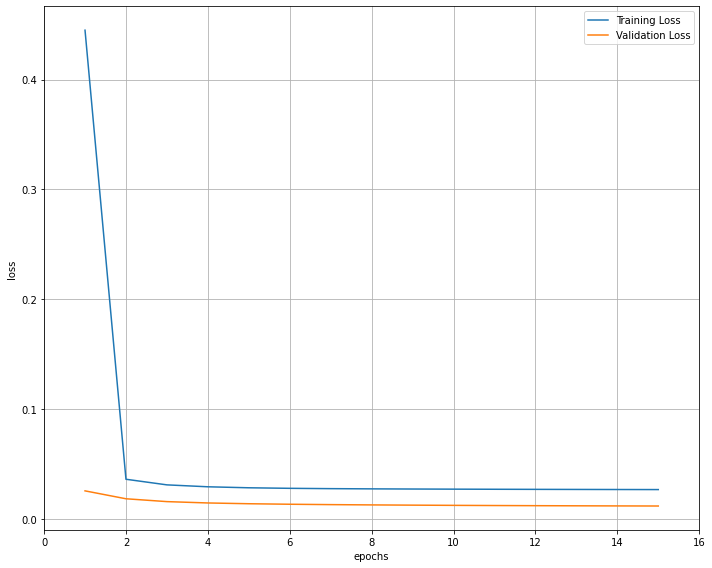

In [ ]:
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(val_loss)+1),val_loss,label='Validation Loss')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.xlim(0, len(train_loss)+1)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches='tight')

##Forte de Copacabana

###Importação de Dados

In [ ]:
df = pd.read_csv('RIO DE JANEIRO - FORTE DE COPACABANA_1997_2022.csv')
del df['Unnamed: 0']
df = df.fillna(0)

df = df.reindex(sorted(df.columns), axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123072 entries, 0 to 123071
Data columns (total 27 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   CD_ESTACAO    123072 non-null  object 
 1   CHUVA         123072 non-null  float64
 2   DC_NOME       123072 non-null  object 
 3   DT_MEDICAO    123072 non-null  object 
 4   HR_MEDICAO    123072 non-null  int64  
 5   PRE_INS       123072 non-null  float64
 6   PRE_MAX       123072 non-null  float64
 7   PRE_MIN       123072 non-null  float64
 8   PTO_INS       123072 non-null  float64
 9   PTO_MAX       123072 non-null  float64
 10  PTO_MIN       123072 non-null  float64
 11  RAD_GLO       123072 non-null  float64
 12  TEM_CPU       123072 non-null  float64
 13  TEM_INS       123072 non-null  float64
 14  TEM_MAX       123072 non-null  float64
 15  TEM_MIN       123072 non-null  float64
 16  TEM_SEN       123072 non-null  float64
 17  TEN_BAT       123072 non-null  float64
 18  UF  

###Preparação de dados

Variáveis de Vento

Text(0, 0.5, 'Wind Velocity [m/s]')

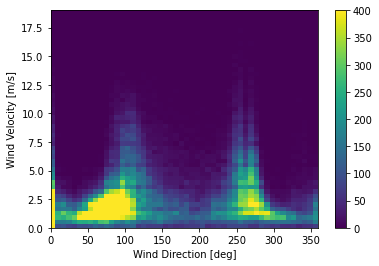

In [ ]:
plt.hist2d(df['VEN_DIR'], df['VEN_VEL'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind Direction [deg]')
plt.ylabel('Wind Velocity [m/s]')

(-12.623222778712067, 15.2, -18.997106207971434, 15.0)

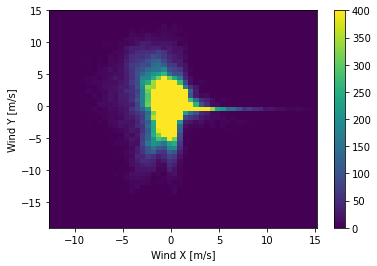

In [ ]:
wv = df['VEN_VEL']
wd_rad = df['VEN_DIR']*np.pi / 180

df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

plt.hist2d(df['Wx'].fillna(0), df['Wy'].fillna(0), bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
ax = plt.gca()
ax.axis('tight')

Variáveis Cíclicas

###Divisão dos Dados

In [ ]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]
print('Conjunto de treinamento')
print(train_df.shape)
print('\n')

print('Conjunto de Validação')
print(val_df.shape)
print('\n')

print('Conjunto de Teste')
print(test_df.shape)

Conjunto de treinamento
(86150, 29)


Conjunto de Validação
(24614, 29)


Conjunto de Teste
(12308, 29)


###Normalização dos Dados

In [ ]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


Removendo os dados descritivos

In [ ]:
print('train_mean')
print(train_mean)
print('\n')

print('train_std')
print(train_std)
print('\n')
                                                                    
train_df = train_df.drop(columns=['DC_NOME','UF','DT_MEDICAO','CD_ESTACAO','VL_LATITUDE','VL_LONGITUDE','HR_MEDICAO'])
print('train_df')
print(train_df)
print('\n')

val_df = val_df.drop(columns=['DC_NOME','UF','DT_MEDICAO','CD_ESTACAO','VL_LATITUDE','VL_LONGITUDE','HR_MEDICAO'])
print('val_df')
print(val_df)
print('\n')

test_df = test_df.drop(columns=['DC_NOME','UF','DT_MEDICAO','CD_ESTACAO','VL_LATITUDE','VL_LONGITUDE','HR_MEDICAO'])
print('test_df')
print(test_df)
print('\n')

###Representação dos Dados

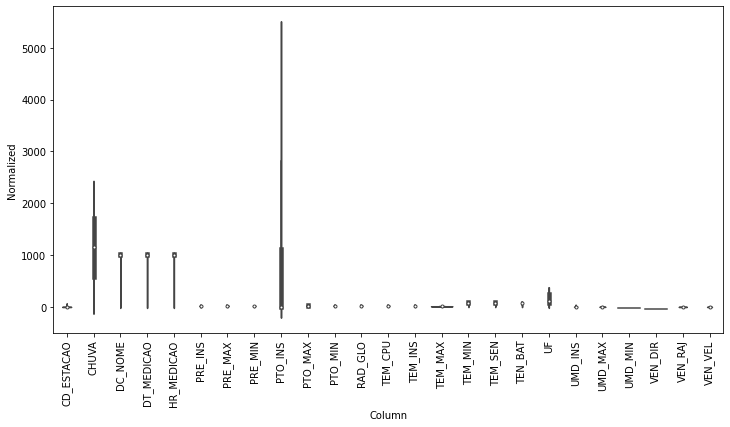

In [ ]:
df2 = df.drop(columns=['DC_NOME','UF','DT_MEDICAO','CD_ESTACAO'])
df_std2 = df2.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x=df_std2['Column'], y=df_std2['Normalized'].astype('float64'))
_ = ax.set_xticklabels(df.keys(), rotation=90)

###Janelamento

In [ ]:
train_arr = np.array(train_df)
val_arr = np.array(val_df)
test_arr = np.array(test_df)


print('Conjunto de Treinamento')
print(train_arr.shape)

print('Conjunto de Validação')
print(val_arr.shape)

print('Conjunto de Teste')
print(test_arr.shape)

Conjunto de Treinamento
(86150, 22)
Conjunto de Validação
(24614, 22)
Conjunto de Teste
(12308, 22)


Criação da função de Janelamento

In [ ]:
def apply_windowing(X, initial_time_step, max_time_step, window_size, idx_target):

  assert idx_target >= 0 and idx_target < X.shape[1]
  assert initial_time_step >= 0
  assert max_time_step >= initial_time_step

  start = initial_time_step
    
  sub_windows = (
        start +
        # expand_dims converts a 1D array to 2D array.
        np.expand_dims(np.arange(window_size), 0) +
        np.expand_dims(np.arange(max_time_step + 1), 0).T
  )
    
  return X[sub_windows], X[window_size:(max_time_step+window_size+1):1, idx_target]

In [ ]:
TIME_WINDOW_SIZE = 3
IDX_TARGET = 11 # index of column 'T (degC)' is 1

train_x, train_y = apply_windowing(train_arr, 
                                  initial_time_step=0, 
                                  max_time_step=len(train_arr)-TIME_WINDOW_SIZE-1, 
                                  window_size = TIME_WINDOW_SIZE, 
                                  idx_target = IDX_TARGET)
train_y = train_y.reshape(-1,1)
print('Janelamento do Conjunto de Treinamento')
print(train_x.shape)
print(train_y.shape)
print('\n')

val_x, val_y = apply_windowing(val_arr, 
                                  initial_time_step=0, 
                                  max_time_step=len(val_arr)-TIME_WINDOW_SIZE-1, 
                                  window_size = TIME_WINDOW_SIZE, 
                                  idx_target = IDX_TARGET)
val_y = val_y.reshape(-1,1)
print('Janelamento do Conjunto de Validação')
print(val_x.shape)
print(val_y.shape)
print('\n')


test_x, test_y = apply_windowing(test_arr, 
                                  initial_time_step=0, 
                                  max_time_step=len(test_arr)-TIME_WINDOW_SIZE-1, 
                                  window_size = TIME_WINDOW_SIZE, 
                                  idx_target = IDX_TARGET)
test_y = test_y.reshape(-1,1)
print('Janelamento do Conjunto de Teste')
print(test_x.shape)
print(test_y.shape)
print('\n')

Janelamento do Conjunto de Treinamento
(86147, 3, 22)
(86147, 1)


Janelamento do Conjunto de Validação
(24611, 3, 22)
(24611, 1)


Janelamento do Conjunto de Teste
(12305, 3, 22)
(12305, 1)




In [ ]:
train_x = torch.from_numpy(train_x.astype('float64'))
train_x = torch.permute(train_x, (0, 2, 1))
train_y = torch.from_numpy(train_y.astype('float64'))
print(train_x.shape)
print(train_y.shape)
print('\n')

val_x = torch.from_numpy(val_x.astype('float64'))
val_x = torch.permute(val_x, (0, 2, 1))
val_y = torch.from_numpy(val_y.astype('float64'))
print(val_x.shape)
print(val_y.shape)
print('\n')

test_x = torch.from_numpy(test_x.astype('float64'))
test_x = torch.permute(test_x, (0, 2, 1))
test_y = torch.from_numpy(test_y.astype('float64'))
print(test_x.shape)
print(test_y.shape)
print('\n')

torch.Size([86147, 22, 3])
torch.Size([86147, 1])


torch.Size([24611, 22, 3])
torch.Size([24611, 1])


torch.Size([12305, 22, 3])
torch.Size([12305, 1])




In [ ]:
train_ds = TensorDataset(train_x, train_y)
val_ds = TensorDataset(val_x, val_y)
test_ds = TensorDataset(test_x, test_y)

BATCH_SIZE = 32
train_loader = torch.utils.data.DataLoader(train_ds, batch_size = BATCH_SIZE, shuffle = False)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size = BATCH_SIZE, shuffle = False)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size = BATCH_SIZE, shuffle = False)

###Treinamento do Modelo

In [ ]:
class Net(nn.Module):
    def __init__(self, in_channels):
        super(Net,self).__init__()
        self.conv1d = nn.Conv1d(in_channels = in_channels, out_channels = 64, kernel_size = 2)
        self.relu = nn.ReLU()#inplace = True)
        self.fc1 = nn.Linear(128,50)
        self.fc2 = nn.Linear(50,1)

    def forward(self,x):
        #print('Input: ', x.shape)
        x = self.conv1d(x)
        #print('After conv1: ', x.shape)
        x = self.relu(x)
        #print('After ReLU: ', x.shape)
        x = x.view(x.shape[0], -1)
        #print('After flatenning: ', x.shape)
        x = self.fc1(x)
        #print(x.shape)
        x = self.relu(x)
        x = self.fc2(x)
        #print('return')
        #print(x.shape)
        return x

In [ ]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    
    # to track the training loss as the model trains
    train_losses = []
    # to track the validation loss as the model trains
    valid_losses = []
    # to track the average training loss per epoch as the model trains
    avg_train_losses = []
    # to track the average validation loss per epoch as the model trains
    avg_valid_losses = [] 
    
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):

        ###################
        # train the model #
        ###################
        model.train() # prep model for training
        for data, target in train_loader:
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data.float())

            # calculate the loss
            loss = criterion(output, target.float())
            
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # record training loss
            train_losses.append(loss.item())

        ######################    
        # validate the model #
        ######################
        model.eval() # prep model for evaluation
        for data, target in val_loader:
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data.float())
            # calculate the loss
            loss = criterion(output, target.float())
            # record validation loss
            valid_losses.append(loss.item())

        # print training/validation statistics 
        # calculate average loss over an epoch
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)
        
        epoch_len = len(str(n_epochs))
        
        print_msg = (f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.5f} ' +
                     f'valid_loss: {valid_loss:.5f}')
        
        print(print_msg)
        
        # clear lists to track next epoch
        train_losses = []
        valid_losses = []
  
    return  model, avg_train_losses, avg_valid_losses

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Net(in_channels=22).to(device)

In [ ]:
criterion = nn.MSELoss()

In [ ]:
for xb, yb in train_loader:
  print(xb.shape)
  print(yb.shape)
  break

torch.Size([32, 22, 3])
torch.Size([32, 1])


Erro relativo antes do treinamento

In [ ]:
test_losses = []
for xb, yb in test_loader:
  output = model(xb.float())
  # calculate the loss
  loss = criterion(output, yb.float())
  # record validation loss
  test_losses.append(loss.item())
test_loss = np.average(test_losses)
print(test_loss)

0.5514118370587949


Treinamento

In [ ]:
n_epochs = 15
model = model.float()
model, train_loss, val_loss = fit(n_epochs, 1e-5, model, train_loader, val_loader, opt_func=torch.optim.Adam)

[ 0/15] train_loss: 0.68281 valid_loss: 0.55749
[ 1/15] train_loss: 0.30709 valid_loss: 0.24871
[ 2/15] train_loss: 0.19446 valid_loss: 0.15022
[ 3/15] train_loss: 0.15852 valid_loss: 0.12214
[ 4/15] train_loss: 0.14268 valid_loss: 0.11020
[ 5/15] train_loss: 0.13253 valid_loss: 0.10258
[ 6/15] train_loss: 0.12572 valid_loss: 0.09758
[ 7/15] train_loss: 0.12140 valid_loss: 0.09436
[ 8/15] train_loss: 0.11863 valid_loss: 0.09224
[ 9/15] train_loss: 0.11679 valid_loss: 0.09082
[10/15] train_loss: 0.11551 valid_loss: 0.08973
[11/15] train_loss: 0.11454 valid_loss: 0.08895
[12/15] train_loss: 0.11372 valid_loss: 0.08827
[13/15] train_loss: 0.11301 valid_loss: 0.08771
[14/15] train_loss: 0.11240 valid_loss: 0.08718


Erro relativo após do treinamento

In [ ]:
test_losses = []
for xb, yb in test_loader:
  output = model(xb.float())
  # calculate the loss
  loss = criterion(output, yb.float())
  # record validation loss
  test_losses.append(loss.item())
test_loss = np.average(test_losses)
print(test_loss)

0.048097761164044406


Gráfico

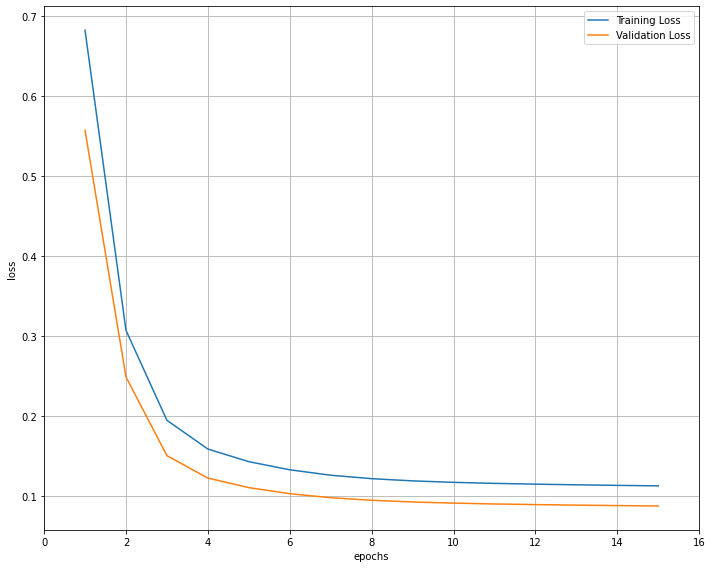

In [ ]:
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(val_loss)+1),val_loss,label='Validation Loss')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.xlim(0, len(train_loss)+1)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches='tight')

#Segundo Experimento do Modelo, para Prever Chuva
Para esse experimento foi utilizado os dados da estação Forte de Copacabana, para prever a variável chuva.

##Bibliotecas
Instalação e importação das bibliotecas que usaremos para o experimento com os modelos

In [ ]:
from numpy import array
import torch
import gc
import torch.nn as nn
from tqdm import tqdm_notebook as tqdm
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import requests, zipfile, io
import matplotlib.pyplot as plt
import os
import seaborn as sns
import sklearn.metrics as skl 
from torch.utils.data import TensorDataset

##Forte de Copacabana

###Importação de Dados

In [ ]:
df = pd.read_csv('RIO DE JANEIRO - FORTE DE COPACABANA_1997_2022.csv')
del df['Unnamed: 0']
df = df.fillna(0)

df = df.reindex(sorted(df.columns), axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123072 entries, 0 to 123071
Data columns (total 27 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   CD_ESTACAO    123072 non-null  object 
 1   CHUVA         123072 non-null  float64
 2   DC_NOME       123072 non-null  object 
 3   DT_MEDICAO    123072 non-null  object 
 4   HR_MEDICAO    123072 non-null  int64  
 5   PRE_INS       123072 non-null  float64
 6   PRE_MAX       123072 non-null  float64
 7   PRE_MIN       123072 non-null  float64
 8   PTO_INS       123072 non-null  float64
 9   PTO_MAX       123072 non-null  float64
 10  PTO_MIN       123072 non-null  float64
 11  RAD_GLO       123072 non-null  float64
 12  TEM_CPU       123072 non-null  float64
 13  TEM_INS       123072 non-null  float64
 14  TEM_MAX       123072 non-null  float64
 15  TEM_MIN       123072 non-null  float64
 16  TEM_SEN       123072 non-null  float64
 17  TEN_BAT       123072 non-null  float64
 18  UF  

###Preparação de dados

Variáveis de Vento

Text(0, 0.5, 'Wind Velocity [m/s]')

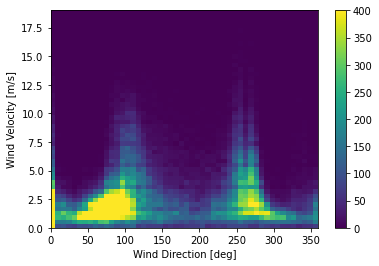

In [ ]:
plt.hist2d(df['VEN_DIR'], df['VEN_VEL'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind Direction [deg]')
plt.ylabel('Wind Velocity [m/s]')

(-12.623222778712067, 15.2, -18.997106207971434, 15.0)

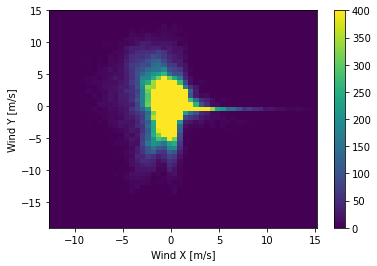

In [ ]:
wv = df['VEN_VEL']
wd_rad = df['VEN_DIR']*np.pi / 180

df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

plt.hist2d(df['Wx'].fillna(0), df['Wy'].fillna(0), bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
ax = plt.gca()
ax.axis('tight')

Variáveis Cíclicas

###Divisão dos Dados

In [ ]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]
print('Conjunto de treinamento')
print(train_df.shape)
print('\n')

print('Conjunto de Validação')
print(val_df.shape)
print('\n')

print('Conjunto de Teste')
print(test_df.shape)

Conjunto de treinamento
(86150, 29)


Conjunto de Validação
(24614, 29)


Conjunto de Teste
(12308, 29)


###Normalização dos Dados

In [ ]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


Removendo os dados descritivos

In [ ]:
print('train_mean')
print(train_mean)
print('\n')

print('train_std')
print(train_std)
print('\n')
                                                                    
train_df = train_df.drop(columns=['DC_NOME','UF','DT_MEDICAO','CD_ESTACAO','VL_LATITUDE','VL_LONGITUDE','HR_MEDICAO'])
print('train_df')
print(train_df)
print('\n')

val_df = val_df.drop(columns=['DC_NOME','UF','DT_MEDICAO','CD_ESTACAO','VL_LATITUDE','VL_LONGITUDE','HR_MEDICAO'])
print('val_df')
print(val_df)
print('\n')

test_df = test_df.drop(columns=['DC_NOME','UF','DT_MEDICAO','CD_ESTACAO','VL_LATITUDE','VL_LONGITUDE','HR_MEDICAO'])
print('test_df')
print(test_df)
print('\n')

train_mean
CHUVA              0.124555
HR_MEDICAO      1149.918746
PRE_INS         1001.297704
PRE_MAX         1001.225970
PRE_MIN         1000.757112
PTO_INS           18.258232
PTO_MAX           18.732207
PTO_MIN           17.765645
RAD_GLO          676.582356
TEM_CPU           25.184469
TEM_INS           23.244489
TEM_MAX           23.782303
TEM_MIN           22.723285
TEM_SEN           21.536972
TEN_BAT           12.792612
UMD_INS           73.807011
UMD_MAX           76.029727
UMD_MIN           71.338909
VEN_DIR          139.261834
VEN_RAJ            5.606398
VEN_VEL            2.673774
VL_LATITUDE      -22.988333
VL_LONGITUDE     -43.190556
Wx                -0.028814
Wy                 0.321112
dtype: float64


train_std
CHUVA           9.716708e-01
HR_MEDICAO      6.922148e+02
PRE_INS         1.005422e+02
PRE_MAX         1.020582e+02
PRE_MIN         1.020118e+02
PTO_INS         5.082874e+00
PTO_MAX         5.194118e+00
PTO_MIN         5.031440e+00
RAD_GLO         1.066447e+03
T

###Representação dos Dados

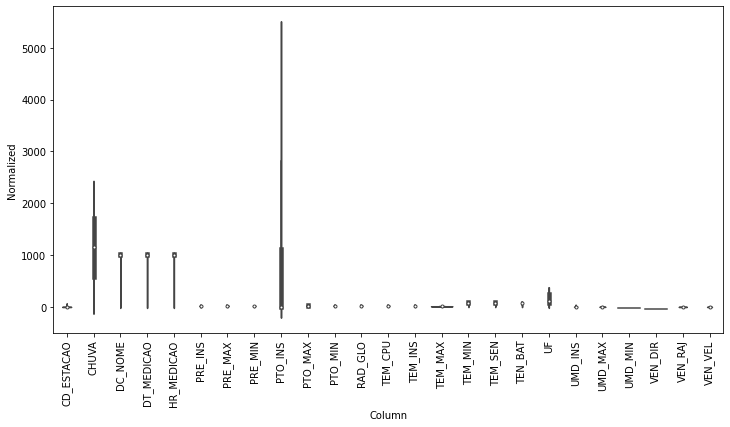

In [ ]:
df2 = df.drop(columns=['DC_NOME','UF','DT_MEDICAO','CD_ESTACAO'])
df_std2 = df2.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x=df_std2['Column'], y=df_std2['Normalized'].astype('float64'))
_ = ax.set_xticklabels(df.keys(), rotation=90)

###Janelamento

In [ ]:
train_arr = np.array(train_df)
val_arr = np.array(val_df)
test_arr = np.array(test_df)


print('Conjunto de Treinamento')
print(train_arr.shape)

print('Conjunto de Validação')
print(val_arr.shape)

print('Conjunto de Teste')
print(test_arr.shape)

Conjunto de Treinamento
(86150, 22)
Conjunto de Validação
(24614, 22)
Conjunto de Teste
(12308, 22)


Criação da função de Janelamento

In [ ]:
def apply_windowing(X, initial_time_step, max_time_step, window_size, idx_target):

  assert idx_target >= 0 and idx_target < X.shape[1]
  assert initial_time_step >= 0
  assert max_time_step >= initial_time_step

  start = initial_time_step
    
  sub_windows = (
        start +
        # expand_dims converts a 1D array to 2D array.
        np.expand_dims(np.arange(window_size), 0) +
        np.expand_dims(np.arange(max_time_step + 1), 0).T
  )
    
  return X[sub_windows], X[window_size:(max_time_step+window_size+1):1, idx_target]

In [ ]:
TIME_WINDOW_SIZE = 3
IDX_TARGET = 0 # index of column 'T (degC)' is 1

train_x, train_y = apply_windowing(train_arr, 
                                  initial_time_step=0, 
                                  max_time_step=len(train_arr)-TIME_WINDOW_SIZE-1, 
                                  window_size = TIME_WINDOW_SIZE, 
                                  idx_target = IDX_TARGET)
train_y = train_y.reshape(-1,1)
print('Janelamento do Conjunto de Treinamento')
print(train_x.shape)
print(train_y.shape)
print('\n')

val_x, val_y = apply_windowing(val_arr, 
                                  initial_time_step=0, 
                                  max_time_step=len(val_arr)-TIME_WINDOW_SIZE-1, 
                                  window_size = TIME_WINDOW_SIZE, 
                                  idx_target = IDX_TARGET)
val_y = val_y.reshape(-1,1)
print('Janelamento do Conjunto de Validação')
print(val_x.shape)
print(val_y.shape)
print('\n')


test_x, test_y = apply_windowing(test_arr, 
                                  initial_time_step=0, 
                                  max_time_step=len(test_arr)-TIME_WINDOW_SIZE-1, 
                                  window_size = TIME_WINDOW_SIZE, 
                                  idx_target = IDX_TARGET)
test_y = test_y.reshape(-1,1)
print('Janelamento do Conjunto de Teste')
print(test_x.shape)
print(test_y.shape)
print('\n')

Janelamento do Conjunto de Treinamento
(86147, 3, 22)
(86147, 1)


Janelamento do Conjunto de Validação
(24611, 3, 22)
(24611, 1)


Janelamento do Conjunto de Teste
(12305, 3, 22)
(12305, 1)




In [ ]:
train_x = torch.from_numpy(train_x.astype('float64'))
train_x = torch.permute(train_x, (0, 2, 1))
train_y = torch.from_numpy(train_y.astype('float64'))
print(train_x.shape)
print(train_y.shape)
print('\n')

val_x = torch.from_numpy(val_x.astype('float64'))
val_x = torch.permute(val_x, (0, 2, 1))
val_y = torch.from_numpy(val_y.astype('float64'))
print(val_x.shape)
print(val_y.shape)
print('\n')

test_x = torch.from_numpy(test_x.astype('float64'))
test_x = torch.permute(test_x, (0, 2, 1))
test_y = torch.from_numpy(test_y.astype('float64'))
print(test_x.shape)
print(test_y.shape)
print('\n')

torch.Size([86147, 22, 3])
torch.Size([86147, 1])


torch.Size([24611, 22, 3])
torch.Size([24611, 1])


torch.Size([12305, 22, 3])
torch.Size([12305, 1])




In [ ]:
train_ds = TensorDataset(train_x, train_y)
val_ds = TensorDataset(val_x, val_y)
test_ds = TensorDataset(test_x, test_y)

BATCH_SIZE = 32
train_loader = torch.utils.data.DataLoader(train_ds, batch_size = BATCH_SIZE, shuffle = False)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size = BATCH_SIZE, shuffle = False)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size = BATCH_SIZE, shuffle = False)

###Treinamento do Modelo

In [ ]:
class Net(nn.Module):
    def __init__(self, in_channels):
        super(Net,self).__init__()
        self.conv1d = nn.Conv1d(in_channels = in_channels, out_channels = 64, kernel_size = 2)
        self.relu = nn.ReLU()#inplace = True)
        self.fc1 = nn.Linear(128,50)
        self.fc2 = nn.Linear(50,1)

    def forward(self,x):
        #print('Input: ', x.shape)
        x = self.conv1d(x)
        #print('After conv1: ', x.shape)
        x = self.relu(x)
        #print('After ReLU: ', x.shape)
        x = x.view(x.shape[0], -1)
        #print('After flatenning: ', x.shape)
        x = self.fc1(x)
        #print(x.shape)
        x = self.relu(x)
        x = self.fc2(x)
        #print('return')
        #print(x.shape)
        return x

In [ ]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    
    # to track the training loss as the model trains
    train_losses = []
    # to track the validation loss as the model trains
    valid_losses = []
    # to track the average training loss per epoch as the model trains
    avg_train_losses = []
    # to track the average validation loss per epoch as the model trains
    avg_valid_losses = [] 
    
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):

        ###################
        # train the model #
        ###################
        model.train() # prep model for training
        for data, target in train_loader:
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data.float())

            # calculate the loss
            loss = criterion(output, target.float())
            
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # record training loss
            train_losses.append(loss.item())

        ######################    
        # validate the model #
        ######################
        model.eval() # prep model for evaluation
        for data, target in val_loader:
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data.float())
            # calculate the loss
            loss = criterion(output, target.float())
            # record validation loss
            valid_losses.append(loss.item())

        # print training/validation statistics 
        # calculate average loss over an epoch
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)
        
        epoch_len = len(str(n_epochs))
        
        print_msg = (f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.5f} ' +
                     f'valid_loss: {valid_loss:.5f}')
        
        print(print_msg)
        
        # clear lists to track next epoch
        train_losses = []
        valid_losses = []
  
    return  model, avg_train_losses, avg_valid_losses

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Net(in_channels=22).to(device)

In [ ]:
criterion = nn.MSELoss()

In [ ]:
for xb, yb in train_loader:
  print(xb.shape)
  print(yb.shape)
  break

torch.Size([32, 22, 3])
torch.Size([32, 1])


Erro relativo antes do treinamento

In [ ]:
test_losses = []
for xb, yb in test_loader:
  output = model(xb.float())
  # calculate the loss
  loss = criterion(output, yb.float())
  # record validation loss
  test_losses.append(loss.item())
test_loss = np.average(test_losses)
print(test_loss)

1.1687900179476998


Treinamento

In [ ]:
n_epochs = 500
model = model.float()
model, train_loss, val_loss = fit(n_epochs, 1e-5, model, train_loader, val_loader, opt_func=torch.optim.Adam)

[  0/500] train_loss: 0.99298 valid_loss: 1.88142
[  1/500] train_loss: 0.96621 valid_loss: 1.83093
[  2/500] train_loss: 0.94333 valid_loss: 1.78322
[  3/500] train_loss: 0.92211 valid_loss: 1.73920
[  4/500] train_loss: 0.90285 valid_loss: 1.70005
[  5/500] train_loss: 0.88565 valid_loss: 1.66503
[  6/500] train_loss: 0.87023 valid_loss: 1.63359
[  7/500] train_loss: 0.85634 valid_loss: 1.60459
[  8/500] train_loss: 0.84385 valid_loss: 1.57911
[  9/500] train_loss: 0.83282 valid_loss: 1.55688
[ 10/500] train_loss: 0.82321 valid_loss: 1.53767
[ 11/500] train_loss: 0.81493 valid_loss: 1.52118
[ 12/500] train_loss: 0.80784 valid_loss: 1.50744
[ 13/500] train_loss: 0.80190 valid_loss: 1.49606
[ 14/500] train_loss: 0.79706 valid_loss: 1.48688
[ 15/500] train_loss: 0.79321 valid_loss: 1.47955
[ 16/500] train_loss: 0.79017 valid_loss: 1.47371
[ 17/500] train_loss: 0.78774 valid_loss: 1.46917
[ 18/500] train_loss: 0.78580 valid_loss: 1.46558
[ 19/500] train_loss: 0.78423 valid_loss: 1.46266


Erro relativo após do treinamento

In [ ]:
test_losses = []
for xb, yb in test_loader:
  output = model(xb.float())
  # calculate the loss
  loss = criterion(output, yb.float())
  # record validation loss
  test_losses.append(loss.item())
test_loss = np.average(test_losses)
print(test_loss)

0.8661530145740306


Gráfico

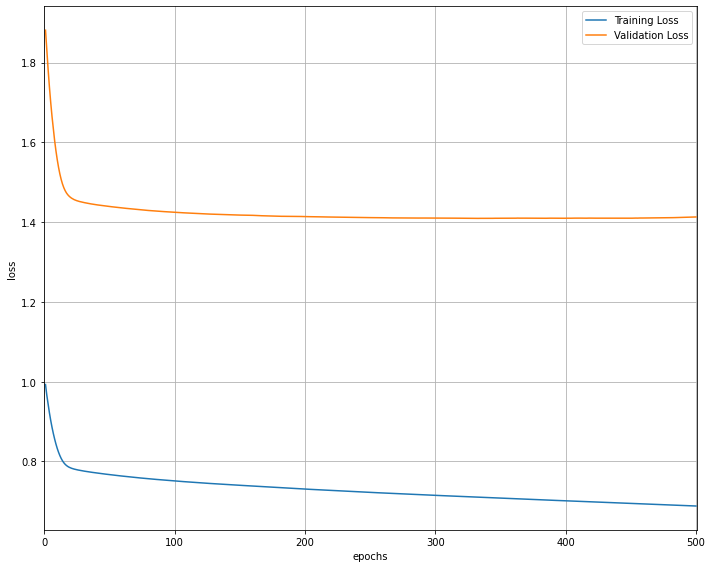

In [ ]:
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(val_loss)+1),val_loss,label='Validation Loss')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.xlim(0, len(train_loss)+1)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches='tight')

In [ ]:
test_losses = []
outputs = []
with torch.no_grad():
  for xb, yb in test_loader:
    output = model(xb.float())
    outputs.append(output)
test_predictions = torch.vstack(outputs).squeeze(1)

In [ ]:
test_predictions.numpy()

array([-0.124336  , -0.14062971, -0.13984916, ..., -0.1260483 ,
       -0.14681846, -0.09784593], dtype=float32)

In [ ]:
test_predictions = torch.cat((test_predictions, torch.tensor([-0.1391931,-0.1391931,-0.1391931])), 0)

In [ ]:
df = pd.read_csv('RIO DE JANEIRO - FORTE DE COPACABANA_1997_2022.csv')
del df['Unnamed: 0']
df = df.fillna(0)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

Erro Absoluto

In [ ]:
skl.mean_absolute_error(test_df['CHUVA'], test_predictions)

0.2580834079622801

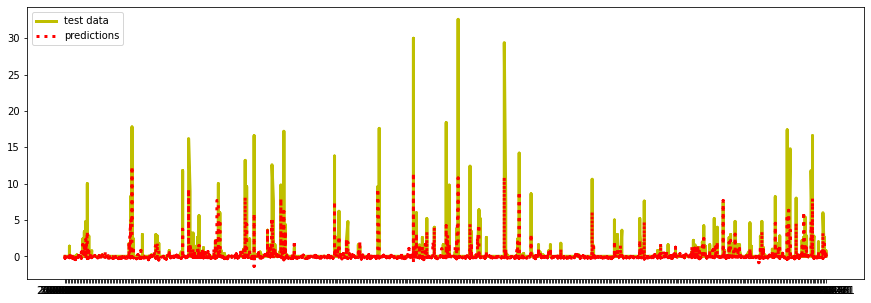

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(test_df['DT_MEDICAO'], test_df['CHUVA'], lw=3, c='y', label='test data')
ax.plot(test_df['DT_MEDICAO'], test_predictions, lw=3, c='r',linestyle = ':', label='predictions')
ax.legend(loc="upper left")
plt.show();

#Terceiro Experimento do Modelo, Inclusão dos dados de Radiossonadagem no conjunto de dados
Para esse experimento foi utilizado os dados da estação Forte de Copacabana com a agregação e interpolação dos dados de radiossonda, para prever a variável chuva.

##Bibliotecas
Instalação e importação das bibliotecas que usaremos para o experimento com os modelos

In [ ]:
from numpy import array
import torch
import gc
import torch.nn as nn
from tqdm import tqdm_notebook as tqdm
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import requests, zipfile, io
import matplotlib.pyplot as plt
import os
import seaborn as sns
import sklearn.metrics as skl 
import sklearn.preprocessing as preproc
from torch.utils.data import TensorDataset

##Forte de Copacabana

###Importação de Dados

In [ ]:
df = pd.read_csv('RIO DE JANEIRO - FORTE DE COPACABANA_CAPE_CIN.csv',na_values=np.nan)
df = df.reindex(sorted(df.columns), axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123072 entries, 0 to 123071
Data columns (total 29 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   CAPE          5385 non-null    float64
 1   CD_ESTACAO    123072 non-null  object 
 2   CHUVA         123072 non-null  float64
 3   CIN           5385 non-null    float64
 4   DC_NOME       123072 non-null  object 
 5   DT_MEDICAO    123072 non-null  object 
 6   HR_MEDICAO    123072 non-null  int64  
 7   PRE_INS       123072 non-null  float64
 8   PRE_MAX       123072 non-null  float64
 9   PRE_MIN       123072 non-null  float64
 10  PTO_INS       123072 non-null  float64
 11  PTO_MAX       123072 non-null  float64
 12  PTO_MIN       123072 non-null  float64
 13  RAD_GLO       123072 non-null  float64
 14  TEM_CPU       123072 non-null  float64
 15  TEM_INS       123072 non-null  float64
 16  TEM_MAX       123072 non-null  float64
 17  TEM_MIN       123072 non-null  float64
 18  TEM_

In [ ]:
df

CAPE CD_ESTACAO  CHUVA  CIN                               DC_NOME  \
0        NaN       A652    0.0  NaN  RIO DE JANEIRO - FORTE DE COPACABANA   
1        NaN       A652    0.0  NaN  RIO DE JANEIRO - FORTE DE COPACABANA   
2        NaN       A652    0.0  NaN  RIO DE JANEIRO - FORTE DE COPACABANA   
3        NaN       A652    0.0  NaN  RIO DE JANEIRO - FORTE DE COPACABANA   
4        NaN       A652    0.0  NaN  RIO DE JANEIRO - FORTE DE COPACABANA   
...      ...        ...    ...  ...                                   ...   
123067   NaN       A652    0.0  NaN  RIO DE JANEIRO - FORTE DE COPACABANA   
123068   NaN       A652    0.0  NaN  RIO DE JANEIRO - FORTE DE COPACABANA   
123069   NaN       A652    0.0  NaN  RIO DE JANEIRO - FORTE DE COPACABANA   
123070   NaN       A652    0.0  NaN  RIO DE JANEIRO - FORTE DE COPACABANA   
123071   NaN       A652    0.0  NaN  RIO DE JANEIRO - FORTE DE COPACABANA   

        DT_MEDICAO  HR_MEDICAO  PRE_INS  PRE_MAX  PRE_MIN  ...  TEN_BAT  UF  \
0       2008-01-01           0   1006.3   1006.3   1005.7  ...     12.5  RJ   
1       2008-01-01         100   1006.7   1006.8   1006.3  ...     12.5  RJ   
2       2008-01-01         200   1006.6   1006.8   1006.6  ...     12.5  RJ   
3       2008-01-01         300   1006.2   1006.6   1006.2  ...     12.4  RJ   
4       2008-01-01         400   1005.9   1006.3   1005.9  ...     12.4  RJ   
...            ...         ...      ...      ...      ...  ...      ...  ..   
123067  2022-01-01        1900   1004.0   1004.4   1004.0  ...     13.6  RJ   
123068  2022-01-01        2000   1004.1   1004.1   1003.8  ...     13.5  RJ   
123069  2022-01-01        2100   1004.4   1004.4   1004.0  ...     13.4  RJ   
123070  2022-01-01        2200   1004.9   1004.9   1004.2  ...     12.7  RJ   
123071  2022-01-01        2300   1005.8   1005.8   1004.9  ...     12.6  RJ   

        UMD_INS  UMD_MAX  UMD_MIN  VEN_DIR  VEN_RAJ  VEN_VEL  VL_LATITUDE  \
0          87.0     88.0     81.0    257.0      5.3      4.3   -22.988333   
1          88.0     88.0     87.0    254.0      5.8      4.1   -22.988333   
2          88.0     88.0     83.0    252.0      6.4      3.7   -22.988333   
3          91.0     91.0     88.0    232.0      4.6      3.2   -22.988333   
4          90.0     92.0     90.0    252.0      7.8      5.1   -22.988333   
...         ...      ...      ...      ...      ...      ...          ...   
123067     76.0     84.0     75.0    100.0      5.5      2.5   -22.988333   
123068     69.0     77.0     67.0     93.0      5.6      1.8   -22.988333   
123069     71.0     72.0     69.0     37.0      6.9      1.1   -22.988333   
123070     72.0     72.0     70.0     30.0      7.9      2.3   -22.988333   
123071     74.0     74.0     70.0     94.0      7.9      2.0   -22.988333   

        VL_LONGITUDE  
0         -43.190556  
1         -43.190556  
2         -43.190556  
3         -43.190556  
4         -43.190556  
...              ...  
123067    -43.190556  
123068    -43.190556  
123069    -43.190556  
123070    -43.190556  
123071    -43.190556  

[123072 rows x 29 columns]

In [ ]:
df['CAPE'][0] = 0
df['CIN'][0] = 0
df = df.interpolate(method='linear')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123072 entries, 0 to 123071
Data columns (total 29 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   CAPE          123072 non-null  float64
 1   CD_ESTACAO    123072 non-null  object 
 2   CHUVA         123072 non-null  float64
 3   CIN           123072 non-null  float64
 4   DC_NOME       123072 non-null  object 
 5   DT_MEDICAO    123072 non-null  object 
 6   HR_MEDICAO    123072 non-null  int64  
 7   PRE_INS       123072 non-null  float64
 8   PRE_MAX       123072 non-null  float64
 9   PRE_MIN       123072 non-null  float64
 10  PTO_INS       123072 non-null  float64
 11  PTO_MAX       123072 non-null  float64
 12  PTO_MIN       123072 non-null  float64
 13  RAD_GLO       123072 non-null  float64
 14  TEM_CPU       123072 non-null  float64
 15  TEM_INS       123072 non-null  float64
 16  TEM_MAX       123072 non-null  float64
 17  TEM_MIN       123072 non-null  float64
 18  TEM_

In [ ]:
df.describe()

CAPE          CHUVA            CIN     HR_MEDICAO  \
count  123072.000000  123072.000000  123072.000000  123072.000000   
mean      425.606812       0.130727     -96.278963    1150.000000   
std       735.445645       1.064494     125.276469     692.221468   
min      -781.556574       0.000000   -1177.005606       0.000000   
25%         4.622816       0.000000    -136.751536     575.000000   
50%       108.884614       0.000000     -50.644855    1150.000000   
75%       651.053946       0.000000      -6.283545    1725.000000   
max     45438.290325      71.600000       0.000000    2300.000000   

             PRE_INS        PRE_MAX        PRE_MIN        PTO_INS  \
count  123072.000000  123072.000000  123072.000000  123072.000000   
mean     1000.447831    1000.394233     999.924829      18.535729   
std       104.755859     106.129223     106.080772       4.688027   
min         0.000000       0.000000       0.000000      -9.200000   
25%      1007.900000    1008.100000    1007.600000      17.200000   
50%      1010.900000    1011.200000    1010.700000      19.400000   
75%      1014.500000    1014.700000    1014.300000      21.300000   
max      1028.800000    1028.800000    1028.500000      28.000000   

             PTO_MAX        PTO_MIN  ...        TEM_SEN        TEN_BAT  \
count  123072.000000  123072.000000  ...  123072.000000  123072.000000   
mean       19.007778      18.051240  ...      21.897077      12.818435   
std         4.781745       4.651585  ...       6.465544       1.498984   
min        -2.200000      -1.500000  ...      -2.400000       0.000000   
25%        17.700000      16.700000  ...      19.700000      12.500000   
50%        19.800000      18.900000  ...      23.000000      12.600000   
75%        21.700000      20.800000  ...      25.800000      13.500000   
max        32.900000      26.900000  ...      38.800000      14.500000   

             UMD_INS        UMD_MAX        UMD_MIN        VEN_DIR  \
count  123072.000000  123072.000000  123072.000000  123072.000000   
mean       74.851973      77.034955      72.432405     144.942611   
std        18.693724      18.525573      18.966740     100.056093   
min         0.000000       0.000000       0.000000       0.000000   
25%        71.000000      74.000000      68.000000      72.000000   
50%        79.000000      81.000000      76.000000     112.000000   
75%        86.000000      87.000000      84.000000     250.000000   
max       100.000000     100.000000     100.000000     360.000000   

             VEN_RAJ        VEN_VEL   VL_LATITUDE   VL_LONGITUDE  
count  123072.000000  123072.000000  1.230720e+05  123072.000000  
mean        5.571938       2.635724 -2.298833e+01     -43.190556  
std         3.226930       2.118580  7.105456e-15       0.000000  
min         0.000000       0.000000 -2.298833e+01     -43.190556  
25%         3.300000       1.200000 -2.298833e+01     -43.190556  
50%         4.900000       2.000000 -2.298833e+01     -43.190556  
75%         7.000000       3.400000 -2.298833e+01     -43.190556  
max        43.100000      19.000000 -2.298833e+01     -43.190556  

[8 rows x 25 columns]

###Preparação de dados

Variáveis de Vento

Text(0, 0.5, 'Wind Velocity [m/s]')

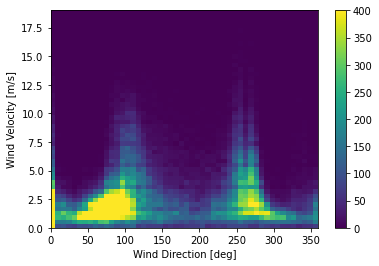

In [ ]:
plt.hist2d(df['VEN_DIR'], df['VEN_VEL'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind Direction [deg]')
plt.ylabel('Wind Velocity [m/s]')

(-12.623222778712067, 15.2, -18.997106207971434, 15.0)

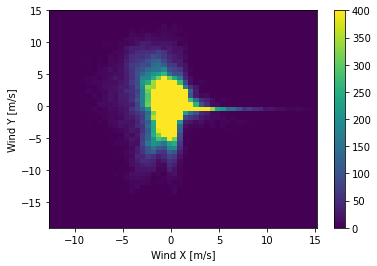

In [ ]:
wv = df['VEN_VEL']
wd_rad = df['VEN_DIR']*np.pi / 180

df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

plt.hist2d(df['Wx'].fillna(0), df['Wy'].fillna(0), bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
ax = plt.gca()
ax.axis('tight')

Variáveis Cíclicas

###Divisão dos Dados

In [ ]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]
print('Conjunto de treinamento')
print(train_df.shape)
print('\n')

print('Conjunto de Validação')
print(val_df.shape)
print('\n')

print('Conjunto de Teste')
print(test_df.shape)

Conjunto de treinamento
(86150, 31)


Conjunto de Validação
(24614, 31)


Conjunto de Teste
(12308, 31)


###Normalização dos Dados

In [ ]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


Removendo os dados descritivos

In [ ]:
print('train_mean')
print(train_mean)
print('\n')

print('train_std')
print(train_std)
print('\n')
                                                                    
train_df = train_df.drop(columns=['DC_NOME','UF','DT_MEDICAO','CD_ESTACAO','VL_LATITUDE','VL_LONGITUDE','HR_MEDICAO'])
print('train_df')
print(train_df)
print('\n')

val_df = val_df.drop(columns=['DC_NOME','UF','DT_MEDICAO','CD_ESTACAO','VL_LATITUDE','VL_LONGITUDE','HR_MEDICAO'])
print('val_df')
print(val_df)
print('\n')

test_df = test_df.drop(columns=['DC_NOME','UF','DT_MEDICAO','CD_ESTACAO','VL_LATITUDE','VL_LONGITUDE','HR_MEDICAO'])
print('test_df')
print(test_df)
print('\n')

train_mean
CAPE             405.649171
CHUVA              0.124555
CIN             -101.402954
HR_MEDICAO      1149.918746
PRE_INS         1001.297704
PRE_MAX         1001.225970
PRE_MIN         1000.757112
PTO_INS           18.258232
PTO_MAX           18.732207
PTO_MIN           17.765645
RAD_GLO          676.582356
TEM_CPU           25.184469
TEM_INS           23.244489
TEM_MAX           23.782303
TEM_MIN           22.723285
TEM_SEN           21.536972
TEN_BAT           12.792612
UMD_INS           73.807011
UMD_MAX           76.029727
UMD_MIN           71.338909
VEN_DIR          139.261834
VEN_RAJ            5.606398
VEN_VEL            2.673774
VL_LATITUDE      -22.988333
VL_LONGITUDE     -43.190556
Wx                -0.028814
Wy                 0.321112
dtype: float64


train_std
CAPE            7.705484e+02
CHUVA           9.716708e-01
CIN             1.306296e+02
HR_MEDICAO      6.922148e+02
PRE_INS         1.005422e+02
PRE_MAX         1.020582e+02
PRE_MIN         1.020118e+02
PTO

In [ ]:
train_df.describe()

CAPE         CHUVA           CIN       PRE_INS       PRE_MAX  \
count  8.615000e+04  8.615000e+04  8.615000e+04  8.615000e+04  8.615000e+04   
mean  -3.431060e-17  2.639277e-17 -1.200871e-16 -8.514966e-16 -1.877845e-15   
std    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
min   -1.498112e+00 -1.281863e-01 -8.233986e+00 -9.958984e+00 -9.810345e+00   
25%   -5.220195e-01 -1.281863e-01 -3.076288e-01  6.467234e-02  6.735403e-02   
50%   -4.147382e-01 -1.281863e-01  3.415146e-01  9.550518e-02  9.674903e-02   
75%    2.456573e-01 -1.281863e-01  7.191271e-01  1.323057e-01  1.330029e-01   
max    5.844233e+01  6.244445e+01  7.762630e-01  2.735400e-01  2.701795e-01   

            PRE_MIN       PTO_INS       PTO_MAX       PTO_MIN       RAD_GLO  \
count  8.615000e+04  8.615000e+04  8.615000e+04  8.615000e+04  8.615000e+04   
mean   1.577628e-15 -5.278553e-18 -9.501396e-17  1.113775e-15  2.045439e-17   
std    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
min   -9.810212e+00 -5.402108e+00 -4.029983e+00 -3.829052e+00 -6.377087e-01   
25%    6.707940e-02 -2.475434e-01 -2.372312e-01 -2.515472e-01 -6.352707e-01   
50%    9.746804e-02  2.049565e-01  1.863249e-01  2.055784e-01 -6.312386e-01   
75%    1.337384e-01  5.787607e-01  5.713758e-01  6.030789e-01  3.828767e-01   
max    2.719577e-01  1.916587e+00  2.727661e+00  1.815455e+00  4.343131e+00   

       ...       TEM_SEN       TEN_BAT       UMD_INS       UMD_MAX  \
count  ...  8.615000e+04  8.615000e+04  8.615000e+04  8.615000e+04   
mean   ...  4.433985e-16  5.238964e-16 -2.111421e-16 -2.480920e-16   
std    ...  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
min    ... -3.447917e+00 -8.722935e+00 -3.640479e+00 -3.759122e+00   
25%    ... -3.078125e-01 -2.677113e-01 -1.877781e-01 -1.497982e-01   
50%    ...  1.819285e-01 -1.995240e-01  2.561405e-01  2.457441e-01   
75%    ...  6.140529e-01  4.141616e-01  6.014106e-01  5.424009e-01   
max    ...  2.486592e+00  1.164222e+00  1.291951e+00  1.185157e+00   

            UMD_MIN       VEN_DIR       VEN_RAJ       VEN_VEL            Wx  \
count  8.615000e+04  8.615000e+04  8.615000e+04  8.615000e+04  8.615000e+04   
mean  -9.567378e-17 -1.477995e-16 -4.057888e-17  5.872390e-17 -2.606286e-17   
std    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
min   -3.491341e+00 -1.367248e+00 -1.709382e+00 -1.214689e+00 -7.189414e+00   
25%   -2.123471e-01 -7.290896e-01 -7.032172e-01 -6.695320e-01 -4.494421e-01   
50%    2.281148e-01 -3.265588e-01 -2.153797e-01 -3.060938e-01  1.644836e-02   
75%    6.196365e-01  1.057754e+00  4.553969e-01  3.753527e-01  4.253137e-01   
max    1.402680e+00  2.167169e+00  1.143174e+01  7.416967e+00  8.693243e+00   

                 Wy  
count  8.615000e+04  
mean  -1.649548e-17  
std    1.000000e+00  
min   -6.504161e+00  
25%   -4.008056e-01  
50%   -4.126275e-02  
75%    4.945999e-01  
max    4.942166e+00  

[8 rows x 24 columns]

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86150 entries, 0 to 86149
Data columns (total 24 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CAPE     86150 non-null  float64
 1   CHUVA    86150 non-null  float64
 2   CIN      86150 non-null  float64
 3   PRE_INS  86150 non-null  float64
 4   PRE_MAX  86150 non-null  float64
 5   PRE_MIN  86150 non-null  float64
 6   PTO_INS  86150 non-null  float64
 7   PTO_MAX  86150 non-null  float64
 8   PTO_MIN  86150 non-null  float64
 9   RAD_GLO  86150 non-null  float64
 10  TEM_CPU  86150 non-null  float64
 11  TEM_INS  86150 non-null  float64
 12  TEM_MAX  86150 non-null  float64
 13  TEM_MIN  86150 non-null  float64
 14  TEM_SEN  86150 non-null  float64
 15  TEN_BAT  86150 non-null  float64
 16  UMD_INS  86150 non-null  float64
 17  UMD_MAX  86150 non-null  float64
 18  UMD_MIN  86150 non-null  float64
 19  VEN_DIR  86150 non-null  float64
 20  VEN_RAJ  86150 non-null  float64
 21  VEN_VEL  861

###Representação dos Dados

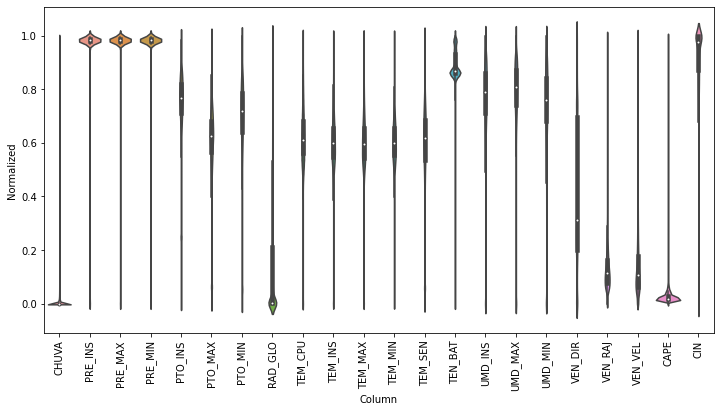

In [ ]:
df2 = df.drop(columns=['DC_NOME','UF','DT_MEDICAO','CD_ESTACAO'])
#df2 = preproc.normalize(df2)
df_std2 = df2.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x=df_std2['Column'], y=df_std2['Normalized'].astype('float64'))
_ = ax.set_xticklabels(df2.keys(), rotation=90)

In [ ]:
df_std2

Column   Normalized
0         CAPE     0.000000
1         CAPE   271.669594
2         CAPE   543.339187
3         CAPE   815.008781
4         CAPE  1086.678374
...        ...          ...
3322939     Wy     2.462019
3322940     Wy     1.797533
3322941     Wy     0.661997
3322942     Wy     1.150000
3322943     Wy     1.995128

[3322944 rows x 2 columns]

###Janelamento

In [ ]:
train_arr = np.array(train_df)
val_arr = np.array(val_df)
test_arr = np.array(test_df)


print('Conjunto de Treinamento')
print(train_arr.shape)

print('Conjunto de Validação')
print(val_arr.shape)

print('Conjunto de Teste')
print(test_arr.shape)

Conjunto de Treinamento
(86150, 24)
Conjunto de Validação
(24614, 24)
Conjunto de Teste
(12308, 24)


Criação da função de Janelamento

In [ ]:
def apply_windowing(X, initial_time_step, max_time_step, window_size, idx_target):

  assert idx_target >= 0 and idx_target < X.shape[1]
  assert initial_time_step >= 0
  assert max_time_step >= initial_time_step

  start = initial_time_step
    
  sub_windows = (
        start +
        # expand_dims converts a 1D array to 2D array.
        np.expand_dims(np.arange(window_size), 0) +
        np.expand_dims(np.arange(max_time_step + 1), 0).T
  )
    
  return X[sub_windows], X[window_size:(max_time_step+window_size+1):1, idx_target]

In [ ]:
TIME_WINDOW_SIZE = 6
IDX_TARGET = 1 # index of column CHUVA

train_x, train_y = apply_windowing(train_arr, 
                                  initial_time_step=0, 
                                  max_time_step=len(train_arr)-TIME_WINDOW_SIZE-1, 
                                  window_size = TIME_WINDOW_SIZE, 
                                  idx_target = IDX_TARGET)
train_y = train_y.reshape(-1,1)
print('Janelamento do Conjunto de Treinamento')
print(train_x.shape)
print(train_y.shape)
print('\n')

val_x, val_y = apply_windowing(val_arr, 
                                  initial_time_step=0, 
                                  max_time_step=len(val_arr)-TIME_WINDOW_SIZE-1, 
                                  window_size = TIME_WINDOW_SIZE, 
                                  idx_target = IDX_TARGET)
val_y = val_y.reshape(-1,1)
print('Janelamento do Conjunto de Validação')
print(val_x.shape)
print(val_y.shape)
print('\n')


test_x, test_y = apply_windowing(test_arr, 
                                  initial_time_step=0, 
                                  max_time_step=len(test_arr)-TIME_WINDOW_SIZE-1, 
                                  window_size = TIME_WINDOW_SIZE, 
                                  idx_target = IDX_TARGET)
test_y = test_y.reshape(-1,1)
print('Janelamento do Conjunto de Teste')
print(test_x.shape)
print(test_y.shape)
print('\n')

Janelamento do Conjunto de Treinamento
(86144, 6, 24)
(86144, 1)


Janelamento do Conjunto de Validação
(24608, 6, 24)
(24608, 1)


Janelamento do Conjunto de Teste
(12302, 6, 24)
(12302, 1)




In [ ]:
train_x = torch.from_numpy(train_x.astype('float64'))
train_x = torch.permute(train_x, (0, 2, 1))
train_y = torch.from_numpy(train_y.astype('float64'))
print(train_x.shape)
print(train_y.shape)
print('\n')

val_x = torch.from_numpy(val_x.astype('float64'))
val_x = torch.permute(val_x, (0, 2, 1))
val_y = torch.from_numpy(val_y.astype('float64'))
print(val_x.shape)
print(val_y.shape)
print('\n')

test_x = torch.from_numpy(test_x.astype('float64'))
test_x = torch.permute(test_x, (0, 2, 1))
test_y = torch.from_numpy(test_y.astype('float64'))
print(test_x.shape)
print(test_y.shape)
print('\n')

torch.Size([86144, 24, 6])
torch.Size([86144, 1])


torch.Size([24608, 24, 6])
torch.Size([24608, 1])


torch.Size([12302, 24, 6])
torch.Size([12302, 1])




In [ ]:
train_ds = TensorDataset(train_x, train_y)
val_ds = TensorDataset(val_x, val_y)
test_ds = TensorDataset(test_x, test_y)

BATCH_SIZE = 32
train_loader = torch.utils.data.DataLoader(train_ds, batch_size = BATCH_SIZE, shuffle = False)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size = BATCH_SIZE, shuffle = False)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size = BATCH_SIZE, shuffle = False)

###Treinamento do Modelo

In [ ]:
class Net(nn.Module):
    def __init__(self, in_channels):
        super(Net,self).__init__()
        self.conv1d = nn.Conv1d(in_channels = in_channels, out_channels = 64, kernel_size = 2)
        self.relu = nn.ReLU()#inplace = True)
        
        #RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x320 and 128x50)
        #RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x320 and 128x320)
        self.fc1 = nn.Linear(320,50)
        self.fc2 = nn.Linear(50,1)

    def forward(self,x):
        #print('Input: ', x.shape)
        x = self.conv1d(x)
        #print('After conv1: ', x.shape)
        x = self.relu(x)
        #print('After ReLU: ', x.shape)
        x = x.view(x.shape[0], -1)
        #print('After flatenning: ', x.shape)
        x = self.fc1(x)
        #print(x.shape)
        x = self.relu(x)
        x = self.fc2(x)
        #print('return')
        #print(x.shape)
        return x

In [ ]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    
    # to track the training loss as the model trains
    train_losses = []
    # to track the validation loss as the model trains
    valid_losses = []
    # to track the average training loss per epoch as the model trains
    avg_train_losses = []
    # to track the average validation loss per epoch as the model trains
    avg_valid_losses = [] 
    
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):

        ###################
        # train the model #
        ###################
        model.train() # prep model for training
        for data, target in train_loader:
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data.float())

            # calculate the loss
            loss = criterion(output, target.float())
            
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # record training loss
            train_losses.append(loss.item())

        ######################    
        # validate the model #
        ######################
        model.eval() # prep model for evaluation
        for data, target in val_loader:
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data.float())
            # calculate the loss
            loss = criterion(output, target.float())
            # record validation loss
            valid_losses.append(loss.item())

        # print training/validation statistics 
        # calculate average loss over an epoch
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)
        
        epoch_len = len(str(n_epochs))
        
        print_msg = (f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.5f} ' +
                     f'valid_loss: {valid_loss:.5f}')
        
        print(print_msg)
        
        # clear lists to track next epoch
        train_losses = []
        valid_losses = []
  
    return  model, avg_train_losses, avg_valid_losses

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Net(in_channels=24).to(device)

In [ ]:
criterion = nn.MSELoss()

In [ ]:
for xb, yb in train_loader:
  print(xb.shape)
  print(yb.shape)
  break

torch.Size([32, 24, 6])
torch.Size([32, 1])


Erro relativo antes do treinamento

In [ ]:
test_losses = []
for xb, yb in test_loader:
  output = model(xb.float())
  # calculate the loss
  loss = criterion(output, yb.float())
  # record validation loss
  test_losses.append(loss.item())
test_loss = np.average(test_losses)
print(test_loss)

1.205985266363245


Treinamento

In [ ]:
n_epochs = 500
model = model.float()
model, train_loss, val_loss = fit(n_epochs, 1e-5, model, train_loader, val_loader, opt_func=torch.optim.Adam)

[  0/500] train_loss: 0.99254 valid_loss: 1.86392
[  1/500] train_loss: 0.96078 valid_loss: 1.81634
[  2/500] train_loss: 0.94122 valid_loss: 1.77628
[  3/500] train_loss: 0.92386 valid_loss: 1.74001
[  4/500] train_loss: 0.90790 valid_loss: 1.70741
[  5/500] train_loss: 0.89325 valid_loss: 1.67847
[  6/500] train_loss: 0.87994 valid_loss: 1.65208
[  7/500] train_loss: 0.86779 valid_loss: 1.62796
[  8/500] train_loss: 0.85663 valid_loss: 1.60590
[  9/500] train_loss: 0.84630 valid_loss: 1.58568
[ 10/500] train_loss: 0.83668 valid_loss: 1.56716
[ 11/500] train_loss: 0.82791 valid_loss: 1.55026
[ 12/500] train_loss: 0.81999 valid_loss: 1.53489
[ 13/500] train_loss: 0.81290 valid_loss: 1.52107
[ 14/500] train_loss: 0.80664 valid_loss: 1.50892
[ 15/500] train_loss: 0.80126 valid_loss: 1.49841
[ 16/500] train_loss: 0.79672 valid_loss: 1.48968
[ 17/500] train_loss: 0.79292 valid_loss: 1.48241
[ 18/500] train_loss: 0.78975 valid_loss: 1.47639
[ 19/500] train_loss: 0.78713 valid_loss: 1.47140


Erro relativo após do treinamento

In [ ]:
test_losses = []
for xb, yb in test_loader:
  output = model(xb.float())
  # calculate the loss
  loss = criterion(output, yb.float())
  # record validation loss
  test_losses.append(loss.item())
test_loss = np.average(test_losses)
print(test_loss)

0.8770174102119908


Gráfico

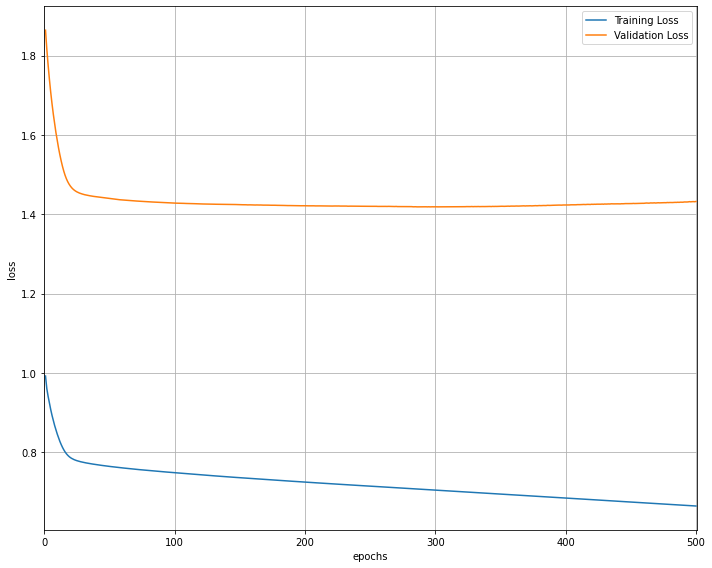

In [ ]:
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(val_loss)+1),val_loss,label='Validation Loss')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.xlim(0, len(train_loss)+1)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches='tight')

In [ ]:
test_losses = []
outputs = []
with torch.no_grad():
  for xb, yb in test_loader:
    output = model(xb.float())
    outputs.append(output)
test_predictions = torch.vstack(outputs).squeeze(1)

In [ ]:
test_predictions.numpy()

array([-0.17625816, -0.11609292, -0.12491076, ...,  0.04284941,
        0.06113856,  0.09228418], dtype=float32)

In [ ]:
test_predictions = torch.cat((test_predictions, torch.tensor([ 0.18153693,0.18153693, 0.18153693,0.18153693,0.18153693, 0.18153693])), 0)

In [ ]:
df = pd.read_csv('RIO DE JANEIRO - FORTE DE COPACABANA_CAPE_CIN.csv',na_values=np.nan)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

Erro Absoluto

In [ ]:
skl.mean_absolute_error(test_df['CHUVA'], test_predictions)

0.3127620795301289

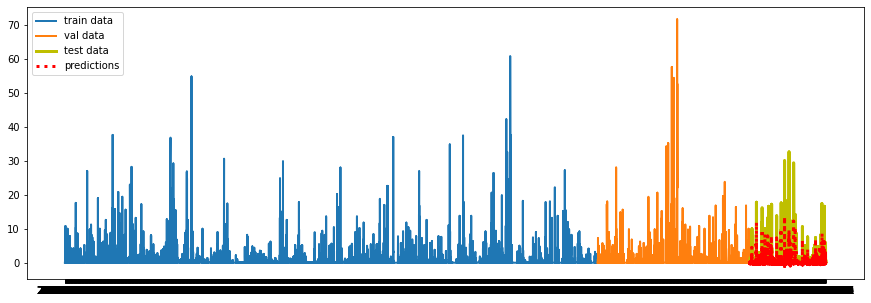

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(train_df['DT_MEDICAO'], train_df['CHUVA'], lw=2, label='train data')
ax.plot(val_df['DT_MEDICAO'], val_df['CHUVA'], lw=2, label='val data')
ax.plot(test_df['DT_MEDICAO'], test_df['CHUVA'], lw=3, c='y', label='test data')
ax.plot(test_df['DT_MEDICAO'], test_predictions, lw=3, c='r',linestyle = ':', label='predictions')
ax.legend(loc="upper left")
plt.show();

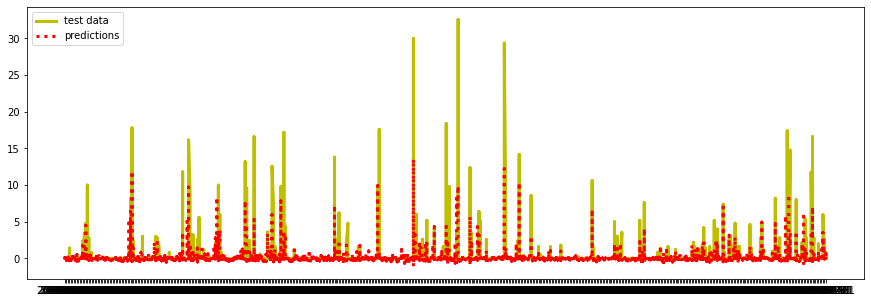

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(test_df['DT_MEDICAO'], test_df['CHUVA'], lw=3, c='y', label='test data')
ax.plot(test_df['DT_MEDICAO'], test_predictions, lw=3, c='r',linestyle = ':', label='predictions')
ax.legend(loc="upper left")
plt.show();

#Quarto Experimento do Modelo, Usando apenas dados de CAPE e CIN
Para esse experimento foi utilizado os dados da estação Forte de Copacabana com a agregação e interpolação dos dados de radiossonda, para prever a variável chuva. Porém utilizamos apenas os dados CAPE e CIN

##Bibliotecas
Instalação e importação das bibliotecas que usaremos para o experimento com os modelos

In [ ]:
from numpy import array
import torch
import gc
import torch.nn as nn
from tqdm import tqdm_notebook as tqdm
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import requests, zipfile, io
import matplotlib.pyplot as plt
import os
import seaborn as sns
import p.metrics as skl 
from torch.utils.data import TensorDataset

##Forte de Copacabana

###Importação de Dados

In [ ]:
df = pd.read_csv('RIO DE JANEIRO - FORTE DE COPACABANA_CAPE_CIN.csv',na_values=np.nan)
df = df.reindex(sorted(df.columns), axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123072 entries, 0 to 123071
Data columns (total 29 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   CAPE          5385 non-null    float64
 1   CD_ESTACAO    123072 non-null  object 
 2   CHUVA         123072 non-null  float64
 3   CIN           5385 non-null    float64
 4   DC_NOME       123072 non-null  object 
 5   DT_MEDICAO    123072 non-null  object 
 6   HR_MEDICAO    123072 non-null  int64  
 7   PRE_INS       123072 non-null  float64
 8   PRE_MAX       123072 non-null  float64
 9   PRE_MIN       123072 non-null  float64
 10  PTO_INS       123072 non-null  float64
 11  PTO_MAX       123072 non-null  float64
 12  PTO_MIN       123072 non-null  float64
 13  RAD_GLO       123072 non-null  float64
 14  TEM_CPU       123072 non-null  float64
 15  TEM_INS       123072 non-null  float64
 16  TEM_MAX       123072 non-null  float64
 17  TEM_MIN       123072 non-null  float64
 18  TEM_

In [ ]:
df

CAPE CD_ESTACAO  CHUVA  CIN                               DC_NOME  \
0        NaN       A652    0.0  NaN  RIO DE JANEIRO - FORTE DE COPACABANA   
1        NaN       A652    0.0  NaN  RIO DE JANEIRO - FORTE DE COPACABANA   
2        NaN       A652    0.0  NaN  RIO DE JANEIRO - FORTE DE COPACABANA   
3        NaN       A652    0.0  NaN  RIO DE JANEIRO - FORTE DE COPACABANA   
4        NaN       A652    0.0  NaN  RIO DE JANEIRO - FORTE DE COPACABANA   
...      ...        ...    ...  ...                                   ...   
123067   NaN       A652    0.0  NaN  RIO DE JANEIRO - FORTE DE COPACABANA   
123068   NaN       A652    0.0  NaN  RIO DE JANEIRO - FORTE DE COPACABANA   
123069   NaN       A652    0.0  NaN  RIO DE JANEIRO - FORTE DE COPACABANA   
123070   NaN       A652    0.0  NaN  RIO DE JANEIRO - FORTE DE COPACABANA   
123071   NaN       A652    0.0  NaN  RIO DE JANEIRO - FORTE DE COPACABANA   

        DT_MEDICAO  HR_MEDICAO  PRE_INS  PRE_MAX  PRE_MIN  ...  TEN_BAT  UF  \
0       2008-01-01           0   1006.3   1006.3   1005.7  ...     12.5  RJ   
1       2008-01-01         100   1006.7   1006.8   1006.3  ...     12.5  RJ   
2       2008-01-01         200   1006.6   1006.8   1006.6  ...     12.5  RJ   
3       2008-01-01         300   1006.2   1006.6   1006.2  ...     12.4  RJ   
4       2008-01-01         400   1005.9   1006.3   1005.9  ...     12.4  RJ   
...            ...         ...      ...      ...      ...  ...      ...  ..   
123067  2022-01-01        1900   1004.0   1004.4   1004.0  ...     13.6  RJ   
123068  2022-01-01        2000   1004.1   1004.1   1003.8  ...     13.5  RJ   
123069  2022-01-01        2100   1004.4   1004.4   1004.0  ...     13.4  RJ   
123070  2022-01-01        2200   1004.9   1004.9   1004.2  ...     12.7  RJ   
123071  2022-01-01        2300   1005.8   1005.8   1004.9  ...     12.6  RJ   

        UMD_INS  UMD_MAX  UMD_MIN  VEN_DIR  VEN_RAJ  VEN_VEL  VL_LATITUDE  \
0          87.0     88.0     81.0    257.0      5.3      4.3   -22.988333   
1          88.0     88.0     87.0    254.0      5.8      4.1   -22.988333   
2          88.0     88.0     83.0    252.0      6.4      3.7   -22.988333   
3          91.0     91.0     88.0    232.0      4.6      3.2   -22.988333   
4          90.0     92.0     90.0    252.0      7.8      5.1   -22.988333   
...         ...      ...      ...      ...      ...      ...          ...   
123067     76.0     84.0     75.0    100.0      5.5      2.5   -22.988333   
123068     69.0     77.0     67.0     93.0      5.6      1.8   -22.988333   
123069     71.0     72.0     69.0     37.0      6.9      1.1   -22.988333   
123070     72.0     72.0     70.0     30.0      7.9      2.3   -22.988333   
123071     74.0     74.0     70.0     94.0      7.9      2.0   -22.988333   

        VL_LONGITUDE  
0         -43.190556  
1         -43.190556  
2         -43.190556  
3         -43.190556  
4         -43.190556  
...              ...  
123067    -43.190556  
123068    -43.190556  
123069    -43.190556  
123070    -43.190556  
123071    -43.190556  

[123072 rows x 29 columns]

In [ ]:
df['CAPE'][0] = 0
df['CIN'][0] = 0
df = df.interpolate(method='linear')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
df = df[["CAPE","CHUVA","CIN"]]

###Divisão dos Dados

In [ ]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]
print('Conjunto de treinamento')
print(train_df.shape)
print('\n')

print('Conjunto de Validação')
print(val_df.shape)
print('\n')

print('Conjunto de Teste')
print(test_df.shape)

Conjunto de treinamento
(86150, 3)


Conjunto de Validação
(24614, 3)


Conjunto de Teste
(12308, 3)


###Normalização dos Dados

In [ ]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

Removendo os dados descritivos

###Representação dos Dados

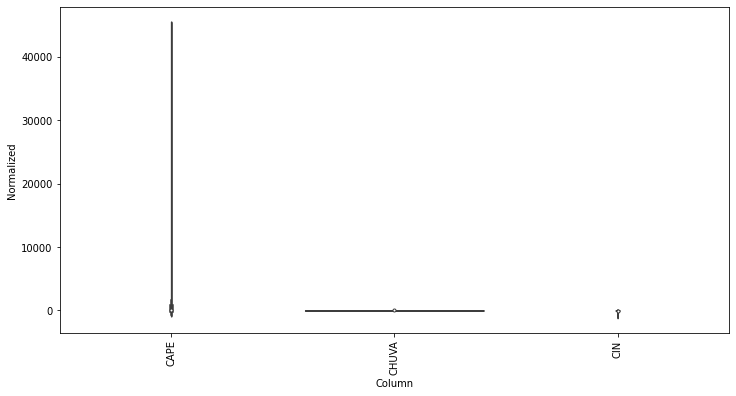

In [ ]:
df2 = df
df_std2 = df2.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x=df_std2['Column'], y=df_std2['Normalized'].astype('float64'))
_ = ax.set_xticklabels(df.keys(), rotation=90)

###Janelamento

In [ ]:
train_arr = np.array(train_df)
val_arr = np.array(val_df)
test_arr = np.array(test_df)


print('Conjunto de Treinamento')
print(train_arr.shape)

print('Conjunto de Validação')
print(val_arr.shape)

print('Conjunto de Teste')
print(test_arr.shape)

Conjunto de Treinamento
(86150, 3)
Conjunto de Validação
(24614, 3)
Conjunto de Teste
(12308, 3)


Criação da função de Janelamento

In [ ]:
def apply_windowing(X, initial_time_step, max_time_step, window_size, idx_target):

  assert idx_target >= 0 and idx_target < X.shape[1]
  assert initial_time_step >= 0
  assert max_time_step >= initial_time_step

  start = initial_time_step
    
  sub_windows = (
        start +
        # expand_dims converts a 1D array to 2D array.
        np.expand_dims(np.arange(window_size), 0) +
        np.expand_dims(np.arange(max_time_step + 1), 0).T
  )
    
  return X[sub_windows], X[window_size:(max_time_step+window_size+1):1, idx_target]

In [ ]:
TIME_WINDOW_SIZE = 6
IDX_TARGET = 1 # index of column CHUVA

train_x, train_y = apply_windowing(train_arr, 
                                  initial_time_step=0, 
                                  max_time_step=len(train_arr)-TIME_WINDOW_SIZE-1, 
                                  window_size = TIME_WINDOW_SIZE, 
                                  idx_target = IDX_TARGET)
train_y = train_y.reshape(-1,1)
print('Janelamento do Conjunto de Treinamento')
print(train_x.shape)
print(train_y.shape)
print('\n')

val_x, val_y = apply_windowing(val_arr, 
                                  initial_time_step=0, 
                                  max_time_step=len(val_arr)-TIME_WINDOW_SIZE-1, 
                                  window_size = TIME_WINDOW_SIZE, 
                                  idx_target = IDX_TARGET)
val_y = val_y.reshape(-1,1)
print('Janelamento do Conjunto de Validação')
print(val_x.shape)
print(val_y.shape)
print('\n')


test_x, test_y = apply_windowing(test_arr, 
                                  initial_time_step=0, 
                                  max_time_step=len(test_arr)-TIME_WINDOW_SIZE-1, 
                                  window_size = TIME_WINDOW_SIZE, 
                                  idx_target = IDX_TARGET)
test_y = test_y.reshape(-1,1)
print('Janelamento do Conjunto de Teste')
print(test_x.shape)
print(test_y.shape)
print('\n')

Janelamento do Conjunto de Treinamento
(86144, 6, 3)
(86144, 1)


Janelamento do Conjunto de Validação
(24608, 6, 3)
(24608, 1)


Janelamento do Conjunto de Teste
(12302, 6, 3)
(12302, 1)




In [ ]:
train_x = torch.from_numpy(train_x.astype('float64'))
train_x = torch.permute(train_x, (0, 2, 1))
train_y = torch.from_numpy(train_y.astype('float64'))
print(train_x.shape)
print(train_y.shape)
print('\n')

val_x = torch.from_numpy(val_x.astype('float64'))
val_x = torch.permute(val_x, (0, 2, 1))
val_y = torch.from_numpy(val_y.astype('float64'))
print(val_x.shape)
print(val_y.shape)
print('\n')

test_x = torch.from_numpy(test_x.astype('float64'))
test_x = torch.permute(test_x, (0, 2, 1))
test_y = torch.from_numpy(test_y.astype('float64'))
print(test_x.shape)
print(test_y.shape)
print('\n')

torch.Size([86144, 3, 6])
torch.Size([86144, 1])


torch.Size([24608, 3, 6])
torch.Size([24608, 1])


torch.Size([12302, 3, 6])
torch.Size([12302, 1])




In [ ]:
train_ds = TensorDataset(train_x, train_y)
val_ds = TensorDataset(val_x, val_y)
test_ds = TensorDataset(test_x, test_y)

BATCH_SIZE = 32
train_loader = torch.utils.data.DataLoader(train_ds, batch_size = BATCH_SIZE, shuffle = False)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size = BATCH_SIZE, shuffle = False)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size = BATCH_SIZE, shuffle = False)

###Treinamento do Modelo

In [ ]:
class Net(nn.Module):
    def __init__(self, in_channels):
        super(Net,self).__init__()
        self.conv1d = nn.Conv1d(in_channels = in_channels, out_channels = 64, kernel_size = 2)
        self.relu = nn.ReLU()#inplace = True)
        
        #RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x320 and 128x50)
        #RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x320 and 128x320)
        self.fc1 = nn.Linear(320,50)
        self.fc2 = nn.Linear(50,1)

    def forward(self,x):
        #print('Input: ', x.shape)
        x = self.conv1d(x)
        #print('After conv1: ', x.shape)
        x = self.relu(x)
        #print('After ReLU: ', x.shape)
        x = x.view(x.shape[0], -1)
        #print('After flatenning: ', x.shape)
        x = self.fc1(x)
        #print(x.shape)
        x = self.relu(x)
        x = self.fc2(x)
        #print('return')
        #print(x.shape)
        return x

In [ ]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    
    # to track the training loss as the model trains
    train_losses = []
    # to track the validation loss as the model trains
    valid_losses = []
    # to track the average training loss per epoch as the model trains
    avg_train_losses = []
    # to track the average validation loss per epoch as the model trains
    avg_valid_losses = [] 
    
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):

        ###################
        # train the model #
        ###################
        model.train() # prep model for training
        for data, target in train_loader:
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data.float())

            # calculate the loss
            loss = criterion(output, target.float())
            
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # record training loss
            train_losses.append(loss.item())

        ######################    
        # validate the model #
        ######################
        model.eval() # prep model for evaluation
        for data, target in val_loader:
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data.float())
            # calculate the loss
            loss = criterion(output, target.float())
            # record validation loss
            valid_losses.append(loss.item())

        # print training/validation statistics 
        # calculate average loss over an epoch
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)
        
        epoch_len = len(str(n_epochs))
        
        print_msg = (f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.5f} ' +
                     f'valid_loss: {valid_loss:.5f}')
        
        print(print_msg)
        
        # clear lists to track next epoch
        train_losses = []
        valid_losses = []
  
    return  model, avg_train_losses, avg_valid_losses

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Net(in_channels=3).to(device)

In [ ]:
criterion = nn.MSELoss()

In [ ]:
for xb, yb in train_loader:
  print(xb.shape)
  print(yb.shape)
  break

torch.Size([32, 3, 6])
torch.Size([32, 1])


Erro relativo antes do treinamento

In [ ]:
test_losses = []
for xb, yb in test_loader:
  output = model(xb.float())
  # calculate the loss
  loss = criterion(output, yb.float())
  # record validation loss
  test_losses.append(loss.item())
test_loss = np.average(test_losses)
print(test_loss)

1.1864232375443755


Treinamento

In [ ]:
n_epochs = 500
model = model.float()
model, train_loss, val_loss = fit(n_epochs, 1e-5, model, train_loader, val_loader, opt_func=torch.optim.Adam)

[  0/500] train_loss: 0.96697 valid_loss: 1.76728
[  1/500] train_loss: 0.90520 valid_loss: 1.66496
[  2/500] train_loss: 0.86836 valid_loss: 1.60425
[  3/500] train_loss: 0.84296 valid_loss: 1.56135
[  4/500] train_loss: 0.82434 valid_loss: 1.53037
[  5/500] train_loss: 0.81130 valid_loss: 1.50854
[  6/500] train_loss: 0.80250 valid_loss: 1.49392
[  7/500] train_loss: 0.79685 valid_loss: 1.48452
[  8/500] train_loss: 0.79333 valid_loss: 1.47848
[  9/500] train_loss: 0.79115 valid_loss: 1.47444
[ 10/500] train_loss: 0.78969 valid_loss: 1.47192
[ 11/500] train_loss: 0.78861 valid_loss: 1.47020
[ 12/500] train_loss: 0.78775 valid_loss: 1.46884
[ 13/500] train_loss: 0.78702 valid_loss: 1.46774
[ 14/500] train_loss: 0.78635 valid_loss: 1.46670
[ 15/500] train_loss: 0.78577 valid_loss: 1.46576
[ 16/500] train_loss: 0.78520 valid_loss: 1.46501
[ 17/500] train_loss: 0.78468 valid_loss: 1.46441
[ 18/500] train_loss: 0.78416 valid_loss: 1.46372
[ 19/500] train_loss: 0.78366 valid_loss: 1.46333


Erro relativo após do treinamento

In [ ]:
test_losses = []
for xb, yb in test_loader:
  output = model(xb.float())
  # calculate the loss
  loss = criterion(output, yb.float())
  # record validation loss
  test_losses.append(loss.item())
test_loss = np.average(test_losses)
print(test_loss)

0.8703925206119936


Gráfico

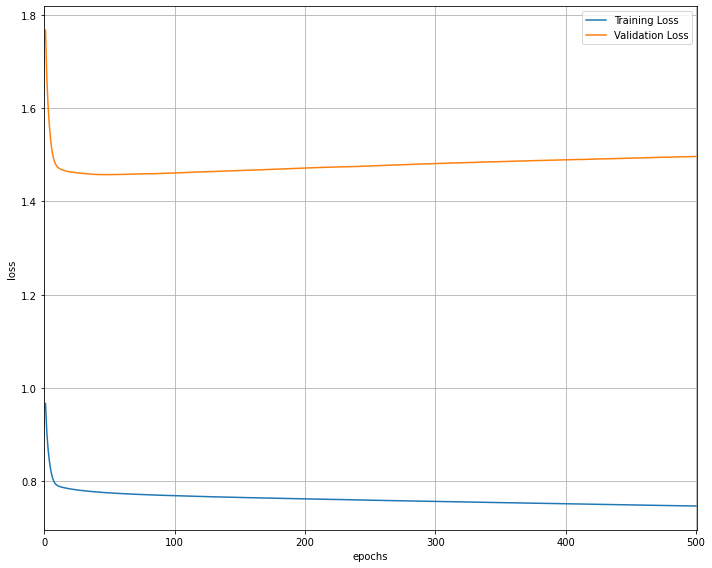

In [ ]:
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(val_loss)+1),val_loss,label='Validation Loss')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.xlim(0, len(train_loss)+1)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches='tight')

In [ ]:
test_losses = []
outputs = []
with torch.no_grad():
  for xb, yb in test_loader:
    output = model(xb.float())
    outputs.append(output)
test_predictions = torch.vstack(outputs).squeeze(1)

In [ ]:
test_predictions.numpy()

array([-0.12988882, -0.12988882, -0.12988882, ..., -0.10598864,
       -0.17167154, -0.15552787], dtype=float32)

In [ ]:
test_predictions = torch.cat((test_predictions, torch.tensor([ 0.18153693,0.18153693, 0.18153693,0.18153693,0.18153693, 0.18153693])), 0)

In [ ]:
df = pd.read_csv('RIO DE JANEIRO - FORTE DE COPACABANA_CAPE_CIN.csv',na_values=np.nan)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

Erro Absoluto

In [ ]:
skl.mean_absolute_error(test_df['CHUVA'], test_predictions)

0.28752973371142687

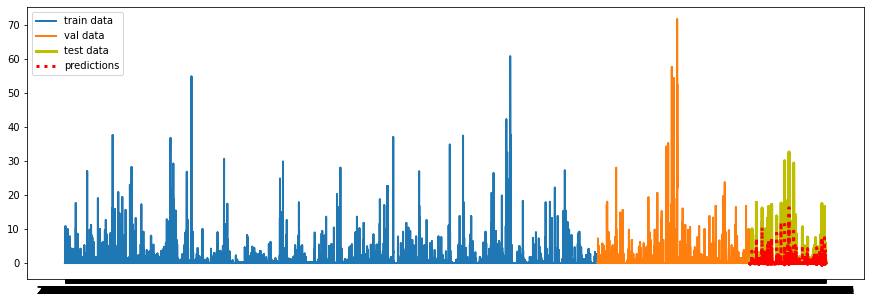

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(train_df['DT_MEDICAO'], train_df['CHUVA'], lw=2, label='train data')
ax.plot(val_df['DT_MEDICAO'], val_df['CHUVA'], lw=2, label='val data')
ax.plot(test_df['DT_MEDICAO'], test_df['CHUVA'], lw=3, c='y', label='test data')
ax.plot(test_df['DT_MEDICAO'], test_predictions, lw=3, c='r',linestyle = ':', label='predictions')
ax.legend(loc="upper left")
plt.show();

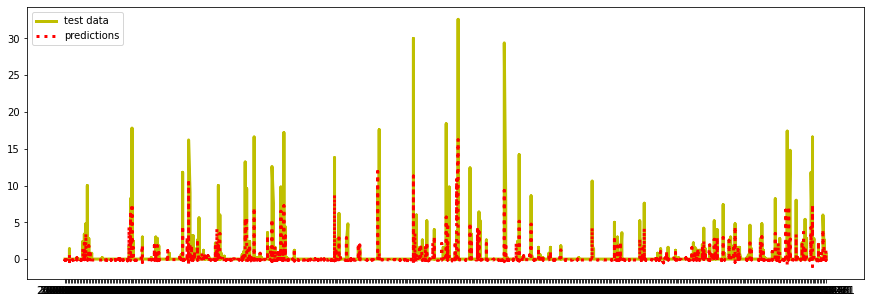

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(test_df['DT_MEDICAO'], test_df['CHUVA'], lw=3, c='y', label='test data')
ax.plot(test_df['DT_MEDICAO'], test_predictions, lw=3, c='r',linestyle = ':', label='predictions')
ax.legend(loc="upper left")
plt.show();

#Quinto Experimento do Modelo, melhora do processo de normalização
Para esse experimento foi utilizado os dados da estação Forte de Copacabana com a agregação e interpolação dos dados de radiossonda, para prever a variável chuva.

##Bibliotecas
Instalação e importação das bibliotecas que usaremos para o experimento com os modelos

In [3]:
from numpy import array
import torch
import gc
import torch.nn as nn
from tqdm import tqdm_notebook as tqdm
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import requests, zipfile, io
import matplotlib.pyplot as plt
import os
import seaborn as sns
import sklearn.metrics as skl 
import sklearn.preprocessing as preproc
from torch.utils.data import TensorDataset

##Forte de Copacabana

###Importação de Dados

In [4]:
df = pd.read_csv('RIO DE JANEIRO - FORTE DE COPACABANA_CAPE_CIN.csv',na_values=np.nan)
df = df.reindex(sorted(df.columns), axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123072 entries, 0 to 123071
Data columns (total 29 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   CAPE          5385 non-null    float64
 1   CD_ESTACAO    123072 non-null  object 
 2   CHUVA         123072 non-null  float64
 3   CIN           5385 non-null    float64
 4   DC_NOME       123072 non-null  object 
 5   DT_MEDICAO    123072 non-null  object 
 6   HR_MEDICAO    123072 non-null  int64  
 7   PRE_INS       123072 non-null  float64
 8   PRE_MAX       123072 non-null  float64
 9   PRE_MIN       123072 non-null  float64
 10  PTO_INS       123072 non-null  float64
 11  PTO_MAX       123072 non-null  float64
 12  PTO_MIN       123072 non-null  float64
 13  RAD_GLO       123072 non-null  float64
 14  TEM_CPU       123072 non-null  float64
 15  TEM_INS       123072 non-null  float64
 16  TEM_MAX       123072 non-null  float64
 17  TEM_MIN       123072 non-null  float64
 18  TEM_

In [5]:
df

CAPE CD_ESTACAO  CHUVA  CIN                               DC_NOME  \
0        NaN       A652    0.0  NaN  RIO DE JANEIRO - FORTE DE COPACABANA   
1        NaN       A652    0.0  NaN  RIO DE JANEIRO - FORTE DE COPACABANA   
2        NaN       A652    0.0  NaN  RIO DE JANEIRO - FORTE DE COPACABANA   
3        NaN       A652    0.0  NaN  RIO DE JANEIRO - FORTE DE COPACABANA   
4        NaN       A652    0.0  NaN  RIO DE JANEIRO - FORTE DE COPACABANA   
...      ...        ...    ...  ...                                   ...   
123067   NaN       A652    0.0  NaN  RIO DE JANEIRO - FORTE DE COPACABANA   
123068   NaN       A652    0.0  NaN  RIO DE JANEIRO - FORTE DE COPACABANA   
123069   NaN       A652    0.0  NaN  RIO DE JANEIRO - FORTE DE COPACABANA   
123070   NaN       A652    0.0  NaN  RIO DE JANEIRO - FORTE DE COPACABANA   
123071   NaN       A652    0.0  NaN  RIO DE JANEIRO - FORTE DE COPACABANA   

        DT_MEDICAO  HR_MEDICAO  PRE_INS  PRE_MAX  PRE_MIN  ...  TEN_BAT  UF  \
0       2008-01-01           0   1006.3   1006.3   1005.7  ...     12.5  RJ   
1       2008-01-01         100   1006.7   1006.8   1006.3  ...     12.5  RJ   
2       2008-01-01         200   1006.6   1006.8   1006.6  ...     12.5  RJ   
3       2008-01-01         300   1006.2   1006.6   1006.2  ...     12.4  RJ   
4       2008-01-01         400   1005.9   1006.3   1005.9  ...     12.4  RJ   
...            ...         ...      ...      ...      ...  ...      ...  ..   
123067  2022-01-01        1900   1004.0   1004.4   1004.0  ...     13.6  RJ   
123068  2022-01-01        2000   1004.1   1004.1   1003.8  ...     13.5  RJ   
123069  2022-01-01        2100   1004.4   1004.4   1004.0  ...     13.4  RJ   
123070  2022-01-01        2200   1004.9   1004.9   1004.2  ...     12.7  RJ   
123071  2022-01-01        2300   1005.8   1005.8   1004.9  ...     12.6  RJ   

        UMD_INS  UMD_MAX  UMD_MIN  VEN_DIR  VEN_RAJ  VEN_VEL  VL_LATITUDE  \
0          87.0     88.0     81.0    257.0      5.3      4.3   -22.988333   
1          88.0     88.0     87.0    254.0      5.8      4.1   -22.988333   
2          88.0     88.0     83.0    252.0      6.4      3.7   -22.988333   
3          91.0     91.0     88.0    232.0      4.6      3.2   -22.988333   
4          90.0     92.0     90.0    252.0      7.8      5.1   -22.988333   
...         ...      ...      ...      ...      ...      ...          ...   
123067     76.0     84.0     75.0    100.0      5.5      2.5   -22.988333   
123068     69.0     77.0     67.0     93.0      5.6      1.8   -22.988333   
123069     71.0     72.0     69.0     37.0      6.9      1.1   -22.988333   
123070     72.0     72.0     70.0     30.0      7.9      2.3   -22.988333   
123071     74.0     74.0     70.0     94.0      7.9      2.0   -22.988333   

        VL_LONGITUDE  
0         -43.190556  
1         -43.190556  
2         -43.190556  
3         -43.190556  
4         -43.190556  
...              ...  
123067    -43.190556  
123068    -43.190556  
123069    -43.190556  
123070    -43.190556  
123071    -43.190556  

[123072 rows x 29 columns]

In [6]:
df['CAPE'][0] = 0
df['CIN'][0] = 0
df = df.interpolate(method='linear')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123072 entries, 0 to 123071
Data columns (total 29 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   CAPE          123072 non-null  float64
 1   CD_ESTACAO    123072 non-null  object 
 2   CHUVA         123072 non-null  float64
 3   CIN           123072 non-null  float64
 4   DC_NOME       123072 non-null  object 
 5   DT_MEDICAO    123072 non-null  object 
 6   HR_MEDICAO    123072 non-null  int64  
 7   PRE_INS       123072 non-null  float64
 8   PRE_MAX       123072 non-null  float64
 9   PRE_MIN       123072 non-null  float64
 10  PTO_INS       123072 non-null  float64
 11  PTO_MAX       123072 non-null  float64
 12  PTO_MIN       123072 non-null  float64
 13  RAD_GLO       123072 non-null  float64
 14  TEM_CPU       123072 non-null  float64
 15  TEM_INS       123072 non-null  float64
 16  TEM_MAX       123072 non-null  float64
 17  TEM_MIN       123072 non-null  float64
 18  TEM_

In [8]:
df.describe()

CAPE          CHUVA            CIN     HR_MEDICAO  \
count  123072.000000  123072.000000  123072.000000  123072.000000   
mean      425.606812       0.130727     -96.278963    1150.000000   
std       735.445645       1.064494     125.276469     692.221468   
min      -781.556574       0.000000   -1177.005606       0.000000   
25%         4.622816       0.000000    -136.751536     575.000000   
50%       108.884614       0.000000     -50.644855    1150.000000   
75%       651.053946       0.000000      -6.283545    1725.000000   
max     45438.290325      71.600000       0.000000    2300.000000   

             PRE_INS        PRE_MAX        PRE_MIN        PTO_INS  \
count  123072.000000  123072.000000  123072.000000  123072.000000   
mean     1000.447831    1000.394233     999.924829      18.535729   
std       104.755859     106.129223     106.080772       4.688027   
min         0.000000       0.000000       0.000000      -9.200000   
25%      1007.900000    1008.100000    1007.600000      17.200000   
50%      1010.900000    1011.200000    1010.700000      19.400000   
75%      1014.500000    1014.700000    1014.300000      21.300000   
max      1028.800000    1028.800000    1028.500000      28.000000   

             PTO_MAX        PTO_MIN  ...        TEM_SEN        TEN_BAT  \
count  123072.000000  123072.000000  ...  123072.000000  123072.000000   
mean       19.007778      18.051240  ...      21.897077      12.818435   
std         4.781745       4.651585  ...       6.465544       1.498984   
min        -2.200000      -1.500000  ...      -2.400000       0.000000   
25%        17.700000      16.700000  ...      19.700000      12.500000   
50%        19.800000      18.900000  ...      23.000000      12.600000   
75%        21.700000      20.800000  ...      25.800000      13.500000   
max        32.900000      26.900000  ...      38.800000      14.500000   

             UMD_INS        UMD_MAX        UMD_MIN        VEN_DIR  \
count  123072.000000  123072.000000  123072.000000  123072.000000   
mean       74.851973      77.034955      72.432405     144.942611   
std        18.693724      18.525573      18.966740     100.056093   
min         0.000000       0.000000       0.000000       0.000000   
25%        71.000000      74.000000      68.000000      72.000000   
50%        79.000000      81.000000      76.000000     112.000000   
75%        86.000000      87.000000      84.000000     250.000000   
max       100.000000     100.000000     100.000000     360.000000   

             VEN_RAJ        VEN_VEL   VL_LATITUDE   VL_LONGITUDE  
count  123072.000000  123072.000000  1.230720e+05  123072.000000  
mean        5.571938       2.635724 -2.298833e+01     -43.190556  
std         3.226930       2.118580  7.105456e-15       0.000000  
min         0.000000       0.000000 -2.298833e+01     -43.190556  
25%         3.300000       1.200000 -2.298833e+01     -43.190556  
50%         4.900000       2.000000 -2.298833e+01     -43.190556  
75%         7.000000       3.400000 -2.298833e+01     -43.190556  
max        43.100000      19.000000 -2.298833e+01     -43.190556  

[8 rows x 25 columns]

###Preparação de dados

Variáveis de Vento

Text(0, 0.5, 'Wind Velocity [m/s]')

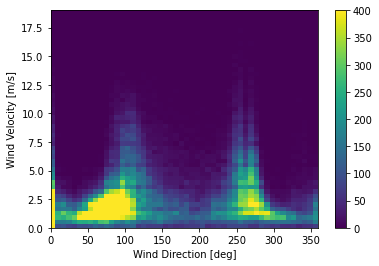

In [9]:
plt.hist2d(df['VEN_DIR'], df['VEN_VEL'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind Direction [deg]')
plt.ylabel('Wind Velocity [m/s]')

(-12.623222778712067, 15.2, -18.997106207971434, 15.0)

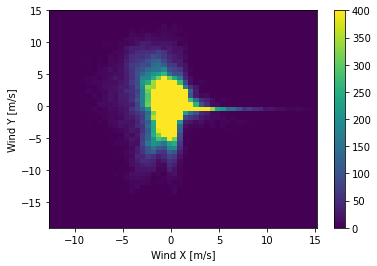

In [10]:
wv = df['VEN_VEL']
wd_rad = df['VEN_DIR']*np.pi / 180

df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

plt.hist2d(df['Wx'].fillna(0), df['Wy'].fillna(0), bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
ax = plt.gca()
ax.axis('tight')

Variáveis Cíclicas

###Divisão dos Dados

In [11]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]
print('Conjunto de treinamento')
print(train_df.shape)
print('\n')

print('Conjunto de Validação')
print(val_df.shape)
print('\n')

print('Conjunto de Teste')
print(test_df.shape)

Conjunto de treinamento
(86150, 31)


Conjunto de Validação
(24614, 31)


Conjunto de Teste
(12308, 31)


###Normalização dos Dados

In [12]:
df1 = df.drop(columns=['DC_NOME','UF','DT_MEDICAO','CD_ESTACAO','VL_LATITUDE','VL_LONGITUDE','HR_MEDICAO'])
df_norm=(df1-df1.min())/(df1.max()-df1.min())
df_norm.describe()

CAPE          CHUVA            CIN        PRE_INS  \
count  123072.000000  123072.000000  123072.000000  123072.000000   
mean        0.026118       0.001826       0.918200       0.972442   
std         0.015912       0.014867       0.106437       0.101823   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.017010       0.000000       0.883814       0.979685   
50%         0.019265       0.000000       0.956971       0.982601   
75%         0.030996       0.000000       0.994661       0.986100   
max         1.000000       1.000000       1.000000       1.000000   

             PRE_MAX        PRE_MIN        PTO_INS        PTO_MAX  \
count  123072.000000  123072.000000  123072.000000  123072.000000   
mean        0.972389       0.972217       0.745584       0.604210   
std         0.103158       0.103141       0.126022       0.136232   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.979879       0.979679       0.709677       0.566952   
50%         0.982893       0.982693       0.768817       0.626781   
75%         0.986295       0.986193       0.819892       0.680912   
max         1.000000       1.000000       1.000000       1.000000   

             PTO_MIN        RAD_GLO  ...        TEM_SEN        TEN_BAT  \
count  123072.000000  123072.000000  ...  123072.000000  123072.000000   
mean        0.688424       0.130352  ...       0.589735       0.884030   
std         0.163788       0.201612  ...       0.156931       0.103378   
min         0.000000       0.000000  ...       0.000000       0.000000   
25%         0.640845       0.000395  ...       0.536408       0.862069   
50%         0.718310       0.001770  ...       0.616505       0.868966   
75%         0.785211       0.212480  ...       0.684466       0.931034   
max         1.000000       1.000000  ...       1.000000       1.000000   

             UMD_INS        UMD_MAX        UMD_MIN        VEN_DIR  \
count  123072.000000  123072.000000  123072.000000  123072.000000   
mean        0.748520       0.770350       0.724324       0.402618   
std         0.186937       0.185256       0.189667       0.277934   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.710000       0.740000       0.680000       0.200000   
50%         0.790000       0.810000       0.760000       0.311111   
75%         0.860000       0.870000       0.840000       0.694444   
max         1.000000       1.000000       1.000000       1.000000   

             VEN_RAJ        VEN_VEL             Wx             Wy  
count  123072.000000  123072.000000  123072.000000  123072.000000  
mean        0.129279       0.138722       0.448970       0.569340  
std         0.074871       0.111504       0.059800       0.085863  
min         0.000000       0.000000       0.000000       0.000000  
25%         0.076566       0.063158       0.423734       0.531279  
50%         0.113689       0.105263       0.453694       0.569886  
75%         0.162413       0.178947       0.476112       0.612816  
max         1.000000       1.000000       1.000000       1.000000  

[8 rows x 24 columns]

In [13]:
n = len(df_norm)
train_df = df_norm[0:int(n*0.7)]
val_df = df_norm[int(n*0.7):int(n*0.9)]
test_df = df_norm[int(n*0.9):]

num_features = df_norm.shape[1]

In [14]:
'''
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std
'''

'\ntrain_mean = train_df.mean()\ntrain_std = train_df.std()\n\ntrain_df = (train_df - train_mean) / train_std\nval_df = (val_df - train_mean) / train_std\ntest_df = (test_df - train_mean) / train_std\n'

Removendo os dados descritivos

In [15]:
train_df.describe()

CAPE         CHUVA           CIN       PRE_INS       PRE_MAX  \
count  86150.000000  86150.000000  86150.000000  86150.000000  86150.000000   
mean       0.025686      0.001740      0.913847      0.973268      0.973198   
std        0.016671      0.013571      0.110985      0.097728      0.099201   
min        0.000710      0.000000      0.000000      0.000000      0.000000   
25%        0.016983      0.000000      0.879705      0.979588      0.979879   
50%        0.018772      0.000000      0.951750      0.982601      0.982795   
75%        0.029782      0.000000      0.993659      0.986198      0.986392   
max        1.000000      0.849162      1.000000      1.000000      1.000000   

            PRE_MIN       PTO_INS       PTO_MAX       PTO_MIN       RAD_GLO  \
count  86150.000000  86150.000000  86150.000000  86150.000000  86150.000000   
mean       0.973026      0.738125      0.596359      0.678368      0.128032   
std        0.099185      0.136636      0.147981      0.177163      0.200769   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.979679      0.704301      0.561254      0.633803      0.000489   
50%        0.982693      0.766129      0.623932      0.714789      0.001299   
75%        0.986291      0.817204      0.680912      0.785211      0.204902   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

       ...       TEM_SEN       TEN_BAT      UMD_INS       UMD_MAX  \
count  ...  86150.000000  86150.000000  86150.00000  86150.000000   
mean   ...      0.580994      0.882249      0.73807      0.760297   
std    ...      0.168506      0.101141      0.20274      0.202254   
min    ...      0.000000      0.000000      0.00000      0.000000   
25%    ...      0.529126      0.855172      0.70000      0.730000   
50%    ...      0.611650      0.862069      0.79000      0.810000   
75%    ...      0.684466      0.924138      0.86000      0.870000   
max    ...      1.000000      1.000000      1.00000      1.000000   

            UMD_MIN       VEN_DIR       VEN_RAJ       VEN_VEL            Wx  \
count  86150.000000  86150.000000  86150.000000  86150.000000  86150.000000   
mean       0.713389      0.386838      0.130079      0.140725      0.452658   
std        0.204331      0.282932      0.076097      0.115853      0.062962   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.670000      0.180556      0.076566      0.063158      0.424360   
50%        0.760000      0.294444      0.113689      0.105263      0.453694   
75%        0.840000      0.686111      0.164733      0.184211      0.479437   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

                 Wy  
count  86150.000000  
mean       0.568231  
std        0.087364  
min        0.000000  
25%        0.533215  
50%        0.564626  
75%        0.611442  
max        1.000000  

[8 rows x 24 columns]

In [16]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86150 entries, 0 to 86149
Data columns (total 24 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CAPE     86150 non-null  float64
 1   CHUVA    86150 non-null  float64
 2   CIN      86150 non-null  float64
 3   PRE_INS  86150 non-null  float64
 4   PRE_MAX  86150 non-null  float64
 5   PRE_MIN  86150 non-null  float64
 6   PTO_INS  86150 non-null  float64
 7   PTO_MAX  86150 non-null  float64
 8   PTO_MIN  86150 non-null  float64
 9   RAD_GLO  86150 non-null  float64
 10  TEM_CPU  86150 non-null  float64
 11  TEM_INS  86150 non-null  float64
 12  TEM_MAX  86150 non-null  float64
 13  TEM_MIN  86150 non-null  float64
 14  TEM_SEN  86150 non-null  float64
 15  TEN_BAT  86150 non-null  float64
 16  UMD_INS  86150 non-null  float64
 17  UMD_MAX  86150 non-null  float64
 18  UMD_MIN  86150 non-null  float64
 19  VEN_DIR  86150 non-null  float64
 20  VEN_RAJ  86150 non-null  float64
 21  VEN_VEL  861

###Representação dos Dados

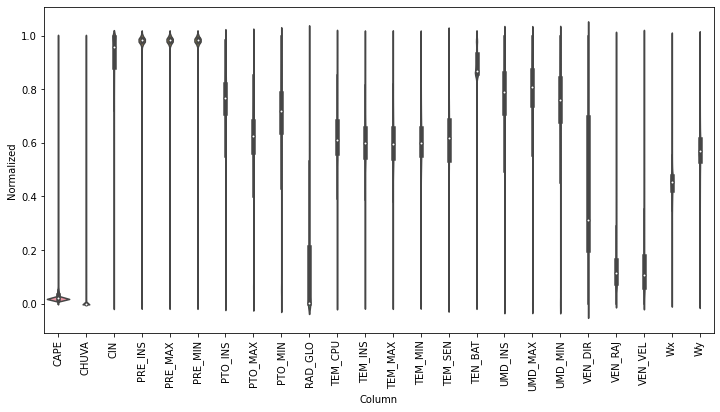

In [17]:
df2 = df_norm
#df2 = preproc.normalize(df2)
df_std2 = df2.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x=df_std2['Column'], y=df_std2['Normalized'].astype('float64'))
_ = ax.set_xticklabels(df2.keys(), rotation=90)

In [18]:
df_std2

Column  Normalized
0         CAPE    0.016910
1         CAPE    0.022787
2         CAPE    0.028665
3         CAPE    0.034543
4         CAPE    0.040421
...        ...         ...
2953723     Wy    0.631204
2953724     Wy    0.611659
2953725     Wy    0.578258
2953726     Wy    0.592612
2953727     Wy    0.617471

[2953728 rows x 2 columns]

###Janelamento

In [19]:
train_arr = np.array(train_df)
val_arr = np.array(val_df)
test_arr = np.array(test_df)


print('Conjunto de Treinamento')
print(train_arr.shape)

print('Conjunto de Validação')
print(val_arr.shape)

print('Conjunto de Teste')
print(test_arr.shape)

Conjunto de Treinamento
(86150, 24)
Conjunto de Validação
(24614, 24)
Conjunto de Teste
(12308, 24)


Criação da função de Janelamento

In [20]:
def apply_windowing(X, initial_time_step, max_time_step, window_size, idx_target):

  assert idx_target >= 0 and idx_target < X.shape[1]
  assert initial_time_step >= 0
  assert max_time_step >= initial_time_step

  start = initial_time_step
    
  sub_windows = (
        start +
        # expand_dims converts a 1D array to 2D array.
        np.expand_dims(np.arange(window_size), 0) +
        np.expand_dims(np.arange(max_time_step + 1), 0).T
  )
    
  return X[sub_windows], X[window_size:(max_time_step+window_size+1):1, idx_target]

In [21]:
TIME_WINDOW_SIZE = 6
IDX_TARGET = 1 # index of column CHUVA

train_x, train_y = apply_windowing(train_arr, 
                                  initial_time_step=0, 
                                  max_time_step=len(train_arr)-TIME_WINDOW_SIZE-1, 
                                  window_size = TIME_WINDOW_SIZE, 
                                  idx_target = IDX_TARGET)
train_y = train_y.reshape(-1,1)
print('Janelamento do Conjunto de Treinamento')
print(train_x.shape)
print(train_y.shape)
print('\n')

val_x, val_y = apply_windowing(val_arr, 
                                  initial_time_step=0, 
                                  max_time_step=len(val_arr)-TIME_WINDOW_SIZE-1, 
                                  window_size = TIME_WINDOW_SIZE, 
                                  idx_target = IDX_TARGET)
val_y = val_y.reshape(-1,1)
print('Janelamento do Conjunto de Validação')
print(val_x.shape)
print(val_y.shape)
print('\n')


test_x, test_y = apply_windowing(test_arr, 
                                  initial_time_step=0, 
                                  max_time_step=len(test_arr)-TIME_WINDOW_SIZE-1, 
                                  window_size = TIME_WINDOW_SIZE, 
                                  idx_target = IDX_TARGET)
test_y = test_y.reshape(-1,1)
print('Janelamento do Conjunto de Teste')
print(test_x.shape)
print(test_y.shape)
print('\n')

Janelamento do Conjunto de Treinamento
(86144, 6, 24)
(86144, 1)


Janelamento do Conjunto de Validação
(24608, 6, 24)
(24608, 1)


Janelamento do Conjunto de Teste
(12302, 6, 24)
(12302, 1)




In [22]:
train_x = torch.from_numpy(train_x.astype('float64'))
train_x = torch.permute(train_x, (0, 2, 1))
train_y = torch.from_numpy(train_y.astype('float64'))
print(train_x.shape)
print(train_y.shape)
print('\n')

val_x = torch.from_numpy(val_x.astype('float64'))
val_x = torch.permute(val_x, (0, 2, 1))
val_y = torch.from_numpy(val_y.astype('float64'))
print(val_x.shape)
print(val_y.shape)
print('\n')

test_x = torch.from_numpy(test_x.astype('float64'))
test_x = torch.permute(test_x, (0, 2, 1))
test_y = torch.from_numpy(test_y.astype('float64'))
print(test_x.shape)
print(test_y.shape)
print('\n')

torch.Size([86144, 24, 6])
torch.Size([86144, 1])


torch.Size([24608, 24, 6])
torch.Size([24608, 1])


torch.Size([12302, 24, 6])
torch.Size([12302, 1])




In [23]:
train_ds = TensorDataset(train_x, train_y)
val_ds = TensorDataset(val_x, val_y)
test_ds = TensorDataset(test_x, test_y)

BATCH_SIZE = 32
train_loader = torch.utils.data.DataLoader(train_ds, batch_size = BATCH_SIZE, shuffle = False)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size = BATCH_SIZE, shuffle = False)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size = BATCH_SIZE, shuffle = False)

###Treinamento do Modelo

In [24]:
class Net(nn.Module):
    def __init__(self, in_channels):
        super(Net,self).__init__()
        self.conv1d = nn.Conv1d(in_channels = in_channels, out_channels = 64, kernel_size = 2)
        self.relu = nn.ReLU()#inplace = True)
        
        #RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x320 and 128x50)
        #RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x320 and 128x320)
        self.fc1 = nn.Linear(320,50)
        self.fc2 = nn.Linear(50,1)

    def forward(self,x):
        #print('Input: ', x.shape)
        x = self.conv1d(x)
        #print('After conv1: ', x.shape)
        x = self.relu(x)
        #print('After ReLU: ', x.shape)
        x = x.view(x.shape[0], -1)
        #print('After flatenning: ', x.shape)
        x = self.fc1(x)
        #print(x.shape)
        x = self.relu(x)
        x = self.fc2(x)
        #print('return')
        #print(x.shape)
        return x

In [25]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    
    # to track the training loss as the model trains
    train_losses = []
    # to track the validation loss as the model trains
    valid_losses = []
    # to track the average training loss per epoch as the model trains
    avg_train_losses = []
    # to track the average validation loss per epoch as the model trains
    avg_valid_losses = [] 
    
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):

        ###################
        # train the model #
        ###################
        model.train() # prep model for training
        for data, target in train_loader:
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data.float())

            # calculate the loss
            loss = criterion(output, target.float())
            
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # record training loss
            train_losses.append(loss.item())

        ######################    
        # validate the model #
        ######################
        model.eval() # prep model for evaluation
        for data, target in val_loader:
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data.float())
            # calculate the loss
            loss = criterion(output, target.float())
            # record validation loss
            valid_losses.append(loss.item())

        # print training/validation statistics 
        # calculate average loss over an epoch
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)
        
        epoch_len = len(str(n_epochs))
        
        print_msg = (f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.5f} ' +
                     f'valid_loss: {valid_loss:.5f}')
        
        print(print_msg)
        
        # clear lists to track next epoch
        train_losses = []
        valid_losses = []
  
    return  model, avg_train_losses, avg_valid_losses

In [26]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Net(in_channels=24).to(device)

In [27]:
criterion = nn.MSELoss()

In [28]:
for xb, yb in train_loader:
  print(xb.shape)
  print(yb.shape)
  break

torch.Size([32, 24, 6])
torch.Size([32, 1])


Erro relativo antes do treinamento

In [29]:
test_losses = []
for xb, yb in test_loader:
  output = model(xb.float())
  # calculate the loss
  loss = criterion(output, yb.float())
  # record validation loss
  test_losses.append(loss.item())
test_loss = np.average(test_losses)
print(test_loss)

0.00027375421395254895


Treinamento

In [30]:
n_epochs = 500
model = model.float()
model, train_loss, val_loss = fit(n_epochs, 1e-5, model, train_loader, val_loader, opt_func=torch.optim.Adam)

[  0/500] train_loss: 0.00023 valid_loss: 0.00038
[  1/500] train_loss: 0.00019 valid_loss: 0.00036
[  2/500] train_loss: 0.00019 valid_loss: 0.00035
[  3/500] train_loss: 0.00018 valid_loss: 0.00035
[  4/500] train_loss: 0.00018 valid_loss: 0.00035
[  5/500] train_loss: 0.00018 valid_loss: 0.00034
[  6/500] train_loss: 0.00018 valid_loss: 0.00034
[  7/500] train_loss: 0.00018 valid_loss: 0.00034
[  8/500] train_loss: 0.00018 valid_loss: 0.00034
[  9/500] train_loss: 0.00018 valid_loss: 0.00034
[ 10/500] train_loss: 0.00018 valid_loss: 0.00034
[ 11/500] train_loss: 0.00018 valid_loss: 0.00033
[ 12/500] train_loss: 0.00018 valid_loss: 0.00033
[ 13/500] train_loss: 0.00018 valid_loss: 0.00033
[ 14/500] train_loss: 0.00017 valid_loss: 0.00033
[ 15/500] train_loss: 0.00017 valid_loss: 0.00033
[ 16/500] train_loss: 0.00017 valid_loss: 0.00033
[ 17/500] train_loss: 0.00017 valid_loss: 0.00033
[ 18/500] train_loss: 0.00017 valid_loss: 0.00032
[ 19/500] train_loss: 0.00017 valid_loss: 0.00032


Erro relativo após do treinamento

In [31]:
test_losses = []
for xb, yb in test_loader:
  output = model(xb.float())
  # calculate the loss
  loss = criterion(output, yb.float())
  # record validation loss
  test_losses.append(loss.item())
test_loss = np.average(test_losses)
print(test_loss)

0.0001628377912676091


Gráfico

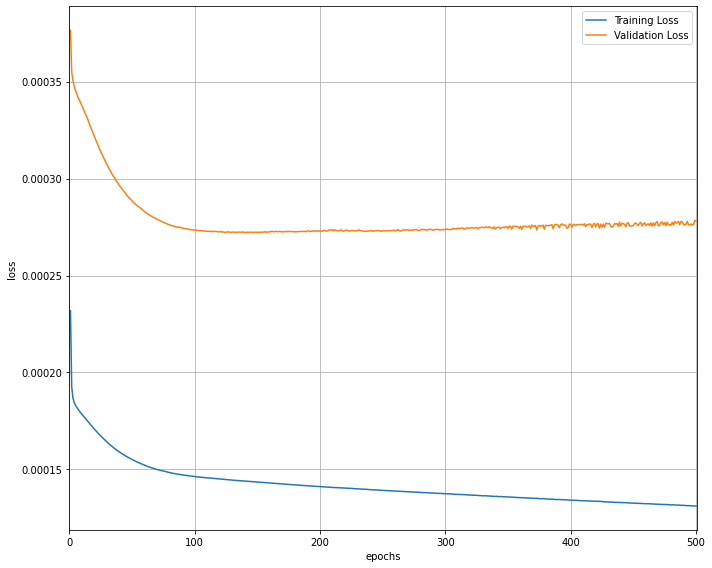

In [32]:
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(val_loss)+1),val_loss,label='Validation Loss')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.xlim(0, len(train_loss)+1)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches='tight')

In [33]:
test_losses = []
outputs = []
with torch.no_grad():
  for xb, yb in test_loader:
    output = model(xb.float())
    outputs.append(output)
test_predictions = torch.vstack(outputs).squeeze(1)

In [34]:
test_predictions.numpy()

array([ 4.1179359e-05, -8.9426339e-04, -1.2056828e-03, ...,
        7.9614669e-04,  3.1629205e-04,  1.3634861e-03], dtype=float32)

In [35]:
test_predictions = torch.cat((test_predictions, torch.tensor([ 0.18153693,0.18153693, 0.18153693,0.18153693,0.18153693, 0.18153693])), 0)

In [36]:
df = pd.read_csv('RIO DE JANEIRO - FORTE DE COPACABANA_CAPE_CIN.csv',na_values=np.nan)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

Erro Absoluto

In [37]:
skl.mean_absolute_error(test_df['CHUVA'], test_predictions)

0.14576161992020342

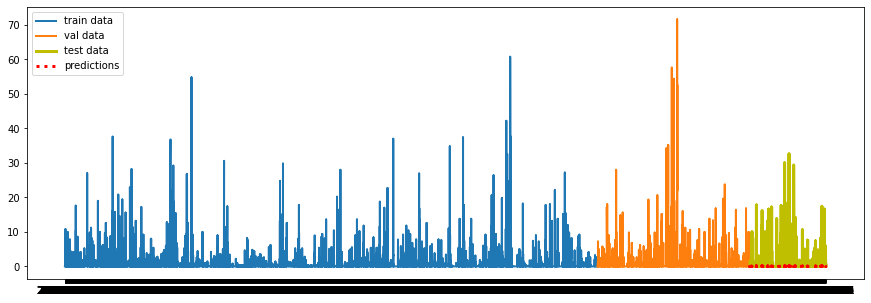

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(train_df['DT_MEDICAO'], train_df['CHUVA'], lw=2, label='train data')
ax.plot(val_df['DT_MEDICAO'], val_df['CHUVA'], lw=2, label='val data')
ax.plot(test_df['DT_MEDICAO'], test_df['CHUVA'], lw=3, c='y', label='test data')
ax.plot(test_df['DT_MEDICAO'], test_predictions, lw=3, c='r',linestyle = ':', label='predictions')
ax.legend(loc="upper left")
plt.show();

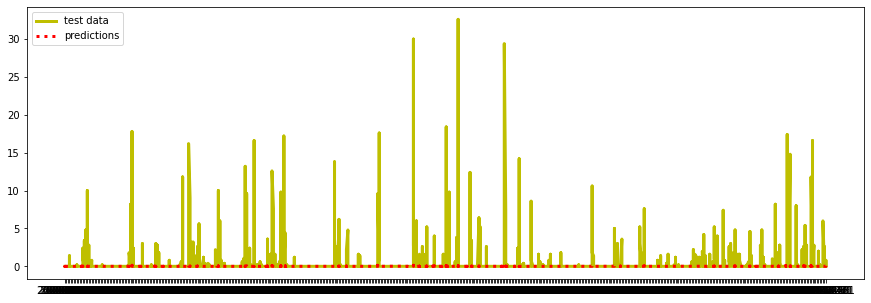

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(test_df['DT_MEDICAO'], test_df['CHUVA'], lw=3, c='y', label='test data')
ax.plot(test_df['DT_MEDICAO'], test_predictions, lw=3, c='r',linestyle = ':', label='predictions')
ax.legend(loc="upper left")
plt.show();